This notebook describes FBXO11 Run 2 (Repeat) and the joint analysis of the data for Figure 2. 

# Load libraries

In [353]:
directory = "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/Analysis/"

In [354]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source(paste0(directory, "utils.R"))
    source(paste0(directory,"misc_funcs.R"))
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")
    library(gridExtra)
    library(patchwork)
})


# Load RNA

In [298]:
rna_dir <- "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/20240924_FBXO11/RNAOutput"

## List subdirectories with *Solo.out/Gene/filtered*
rna_paths = list.dirs(path = rna_dir, full.names = TRUE, recursive = TRUE)[grepl('raw',
                                  list.dirs(path = rna_dir, full.names = TRUE, recursive = TRUE))]
rna_paths %>% head(2)

[1] "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/20240924_FBXO11/RNAOutput/FBXO11_1/Solo.out/GeneFull/raw"
[2] "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/20240924_FBXO11/RNAOutput/FBXO11_2/Solo.out/GeneFull/raw"

In [299]:
#import all expression data
exprs <- do.call(cbind, lapply(rna_paths, function(run){
    name = str_split(run, '/RNAOutput/') %>% map(2) %>% str_replace('/Solo.out/GeneFull/raw', '')
    exprs = read10x_mtx(run, name)
})
)

In [300]:
#add meta data
meta <- data.frame(cell = colnames(exprs),
                  plate = exprs %>% colnames %>% str_split('_') %>% map(2) %>% unlist)
rownames(meta) = colnames(exprs)

# Load ADT

In [301]:
adt_dir <- 'ADTOutput'

## List subdirectories with *Solo.out/Gene/filtered*
adt_paths <- list.dirs(path = adt_dir, full.names = TRUE, recursive = TRUE)[endsWith(list.dirs(path = adt_dir, 
                                                                                              full.names = TRUE, recursive = TRUE), 
                                                                                    'counts_unfiltered')]
adt_paths %>% head(2)

[1] "ADTOutput/FBXO11_1/counts_unfiltered"
[2] "ADTOutput/FBXO11_2/counts_unfiltered"

In [302]:
counts_ADT <- do.call(cbind, lapply(adt_paths, function(run){
    name = str_split(run, 'ADTOutput/') %>% map(2) %>% str_replace('/counts_unfiltered', '')
    counts = read10x_kallisto(run, name)
})
)

In [303]:
meta_ADT <- data.frame(cell_adt = colnames(counts_ADT),
                  plate = counts_ADT %>% colnames %>% str_split('_') %>% map(2) %>% unlist)


In [304]:
# Filter non-human ADTs and cells not called by STAR (RNA)
counts_ADT_filt <- counts_ADT[rownames(counts_ADT)[!grepl('^Mouse|^Rat|^Hamster', rownames(counts_ADT))],]

# Read in DNA. Jump below to read in if already performed

In [11]:
DNAfiles = "DNAOutput_R2/"

In [95]:
#Alleles Function for Import - Updated- Fixed Naming to Automate and Changed to Capture the top 10 alleles per cell. 
AllelesFunction <- 
function (filepath, number_of_alleles = 10, folder_name="Alleles") #Filepath is the folder with all the allele tables. 
{
    files <- list.files(path = filepath, pattern = ".txt$", full.names = T, 
        recursive = T) 
    
    matrix <- suppressMessages({
        suppressWarnings({
            lapply(files, read_tsv, n_max = number_of_alleles, col_select = c(1, 
                5, 6, 7, 8, 9))
        })
    })
    names(matrix) <- lapply(files, FUN = 
      function(x) { 
          paste0(substr(x, str_locate(x, paste0(folder_name, "/"))[2]+1, str_locate(x, "/CRISPRessoBatch_on_batch")[1]-1), #modified for Full
                            "_", 
                             substr(x, str_locate(x, "CRISPResso_on_([A-Z])(\\d)")[2]-1, str_locate(x, "/Alleles_frequency_table.txt")[1]-1))})
    
    matrix <- bind_rows(matrix, .id = "Plate_Well")
    return(matrix)
}

In [115]:
#Upload all Alleles
alleles_DNA <- AllelesFunction(DNAfiles, folder_name="DNAOutput_R2/")

In [116]:
alleles_DNA %>% write_csv("alleles_DNA.csv")

In [3]:
alleles_DNA <- read_csv("alleles_DNA.csv")

Rows: 29390 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Plate_Well, Aligned_Sequence
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
alleles_DNA<- alleles_DNA %>% separate(Plate_Well, into = c("Experiment","Plate", "Well_ID")) 

In [6]:
alleles_DNA<- mutate(alleles_DNA, Barcode_DNA = paste0(Experiment, Plate))

In [7]:
alleles_DNA %>% head

Experiment Plate Well_ID
1 FBXO11     1     A1     
2 FBXO11     1     A1     
3 FBXO11     1     A1     
4 FBXO11     1     A1     
5 FBXO11     1     A1     
6 FBXO11     1     A1     
  Aligned_Sequence                                                                                                                                                                        
1 GGCCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAA-GCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTGCCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG-- 
2 GCCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTGCCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG--  
3 GCCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG--  
4 CCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTGCCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG--  
5 CGGCCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAA--GCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTGCCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG--
6 GGCCTTAAAGCCTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAA-GCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGG-- 
  n_deleted n_inserted n_mutated #Reads %Reads    Barcode_DNA
1 0         0          0         13     16.049383 FBXO111    
2 0         0          0         12     14.814815 FBXO111    
3 0         0          0          7      8.641975 FBXO111    
4 0         0          0          5      6.172840 FBXO111    
5 0         0          0          3      3.703704 FBXO111    
6 0         0          0          3      3.703704 FBXO111

# IndexFlow

In [8]:
IndexFlow <- read_delim("FBXO11_indexSort.txt")

Rows: 2688 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): well, cellType, smp, bc, cellTypeNew
dbl (3): SSC_A, CD45, CD40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
#Fixing column names
IndexFlow <- 
IndexFlow %>% separate(smp, into = c("Experiment", "Plate","extra", "sample")) %>% mutate(plate_well = paste0(Experiment, Plate, well))

In [10]:
IndexFlow %>% head

well cellType  Experiment Plate extra sample SSC_A    CD45      CD40     
1 A1   FBXO11 KO FBXO11     1     DNA   S1     17703.00  38.19718  71.69168
2 A2   FBXO11 KO FBXO11     1     DNA   S1     14138.09  32.63412 246.93243
3 A3   NTC       FBXO11     1     DNA   S1     21192.00 378.55152 649.38163
4 A4   FBXO11 KO FBXO11     1     DNA   S1     14138.09  19.89886  45.72527
5 A5   FBXO11 KO FBXO11     1     DNA   S1     16180.22  26.65516 225.69172
6 A6   FBXO11 KO FBXO11     1     DNA   S1     21673.92  29.16378  85.82104
  bc         cellTypeNew plate_well
1 AACACGAGGA Edited      FBXO111A1 
2 AACCAATGAC Edited      FBXO111A2 
3 AACGACTCCA NTC         FBXO111A3 
4 AACGTATACC Edited      FBXO111A4 
5 AACGTTGCAG Edited      FBXO111A5 
6 AAGACAAGTC Edited      FBXO111A6

In [11]:
theme_gy <- function (base_size = 23) 
{
    theme_bw(base_size = base_size) + theme(plot.title = element_text(hjust = 0.5, 
        size = (base_size + 2)), legend.title = element_text(face = "italic"), 
        axis.title = element_text(size = 26), axis.text = element_text(size = base_size ))
}

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


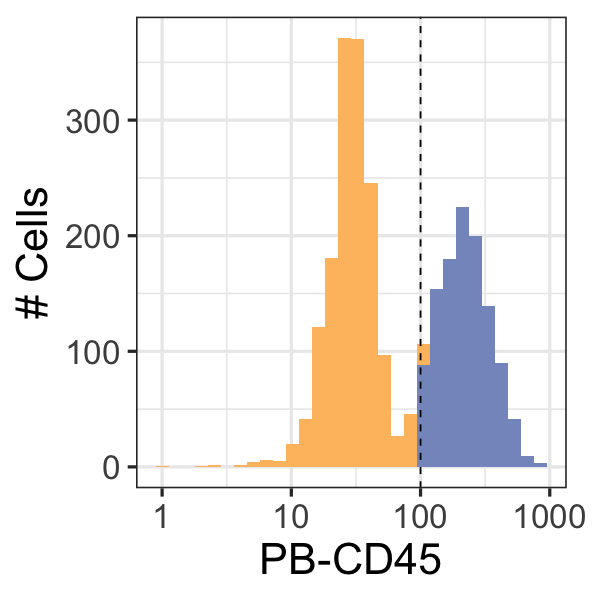

In [12]:
fig.size(5,5)
IndexFlow %>% 
ggplot() +  
geom_histogram(aes(x = CD45, fill = cellType)) + xlim(0,2000) + 
scale_x_log10()+
theme_gy(20)+
scale_fill_manual(values = c(
          "NTC" = "#8698C7",
          "FBXO11 KO" = "#FDBF6E",
          "A/G" = "#C994C7",
          "A/A" = "#DD1C77", 
          "G/G" = "grey"))+   
theme(legend.position = "none", 
     plot.margin = margin(10, 20, 10, 10)) +
geom_vline(xintercept = 100, linetype =2) +
xlab("PB-CD45") + 
ylab("# Cells") 

# DNA analysis

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


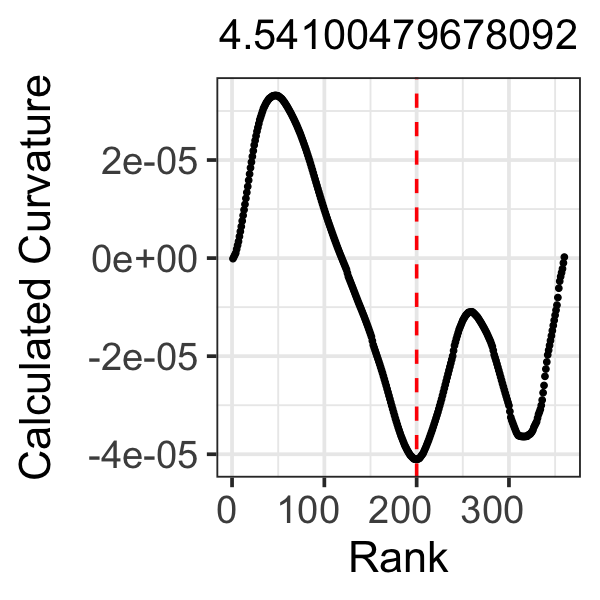

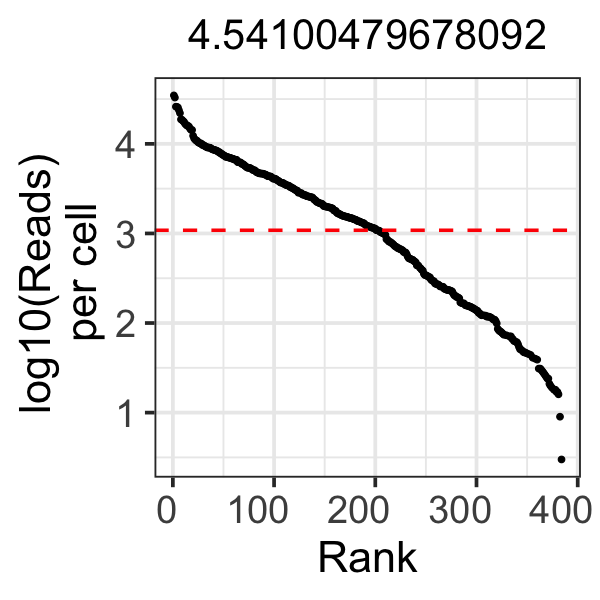

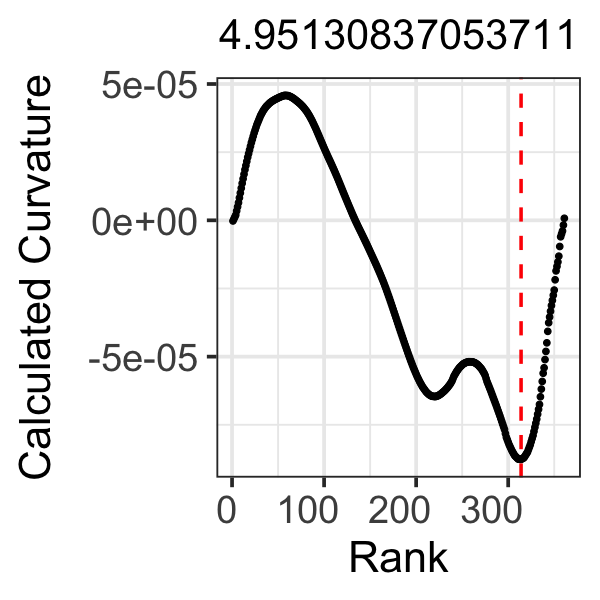

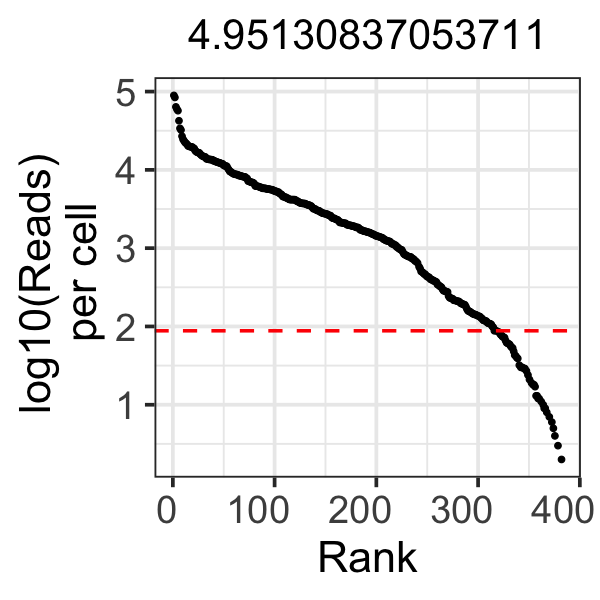

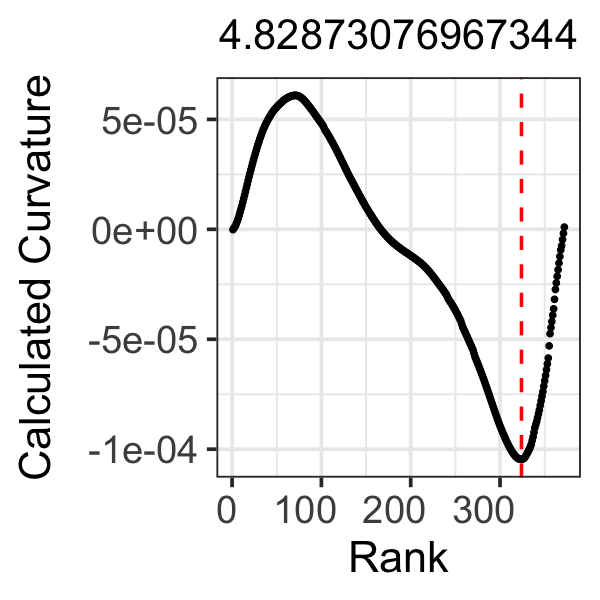

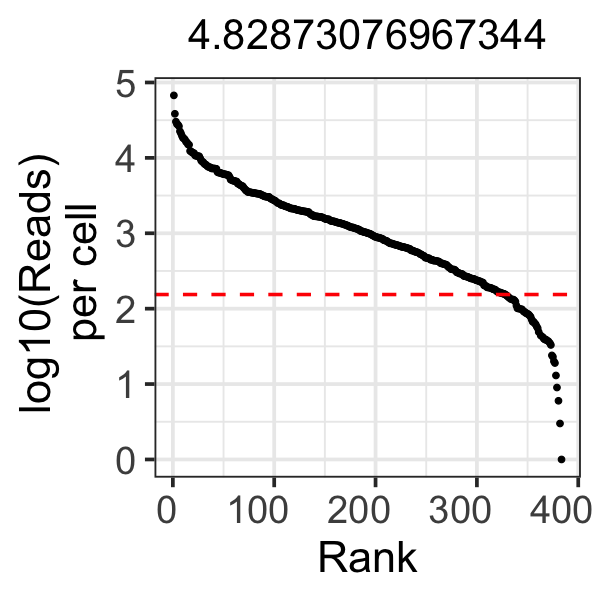

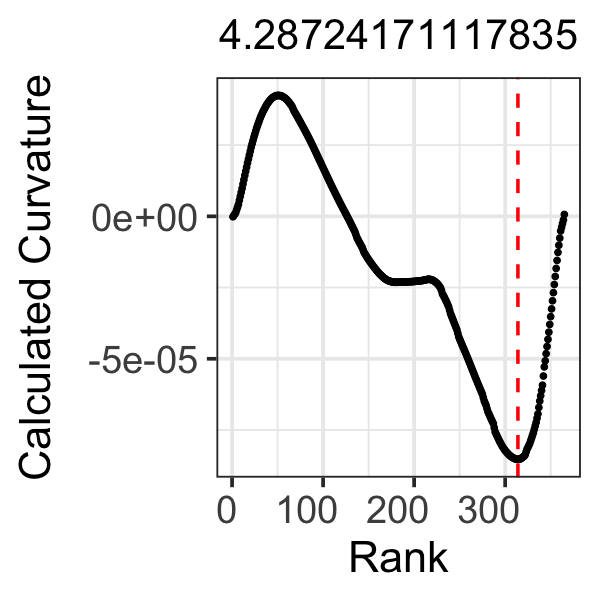

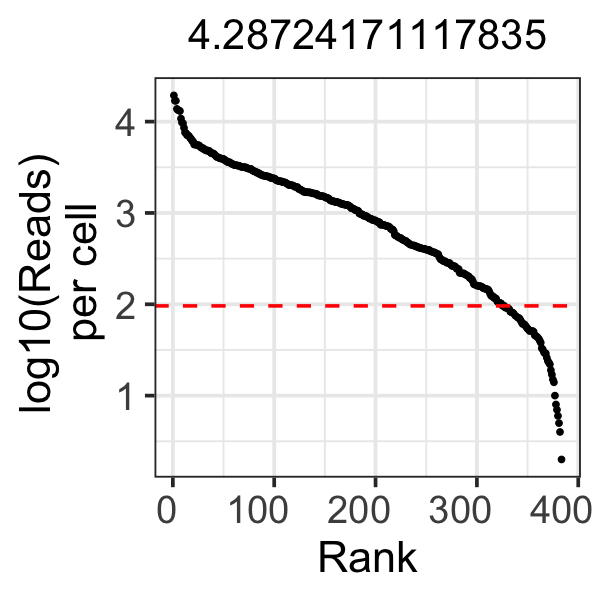

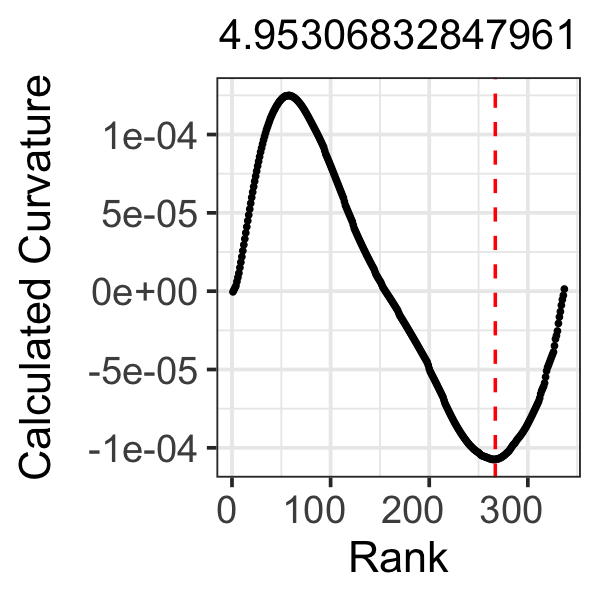

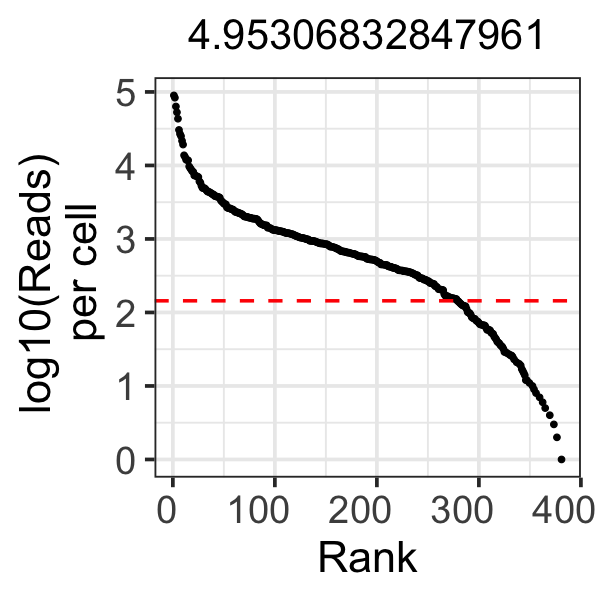

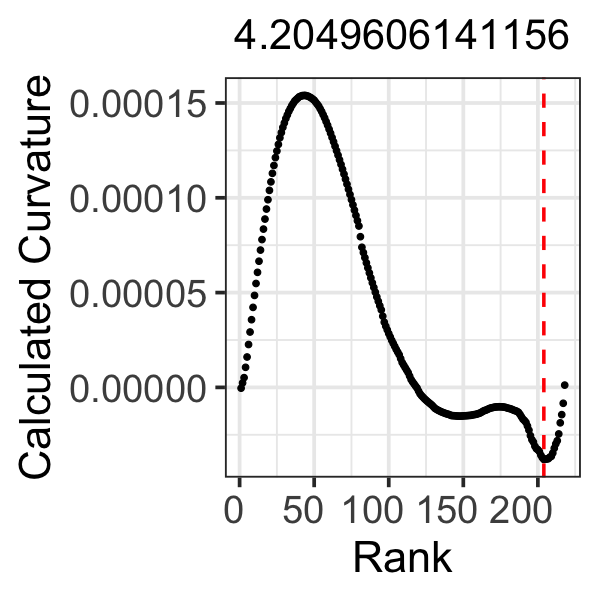

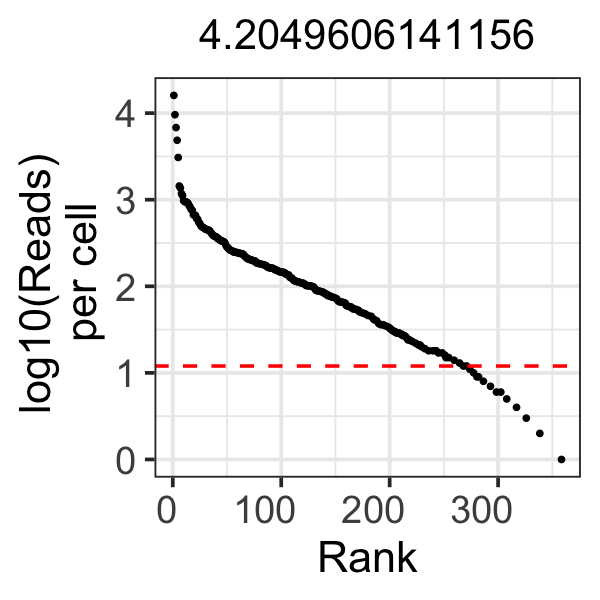

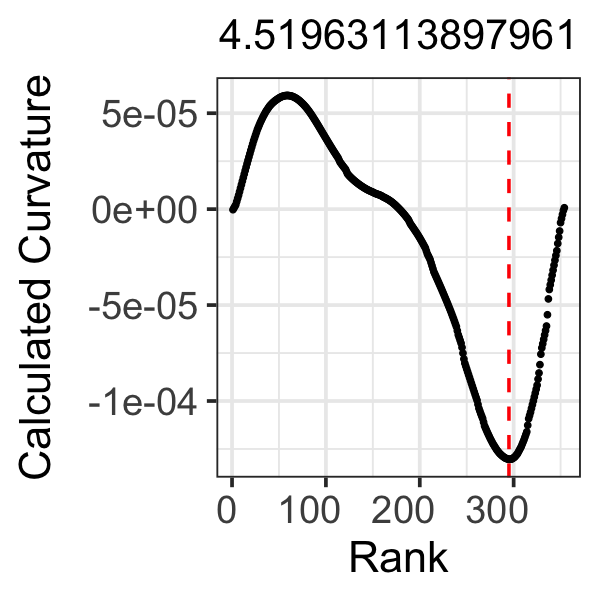

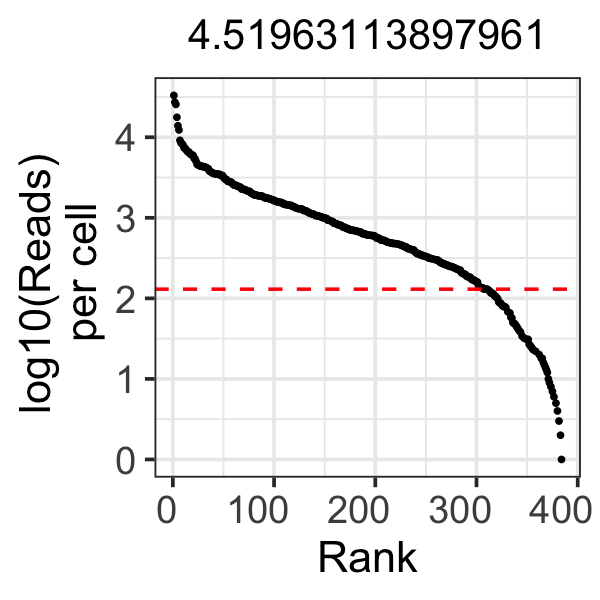

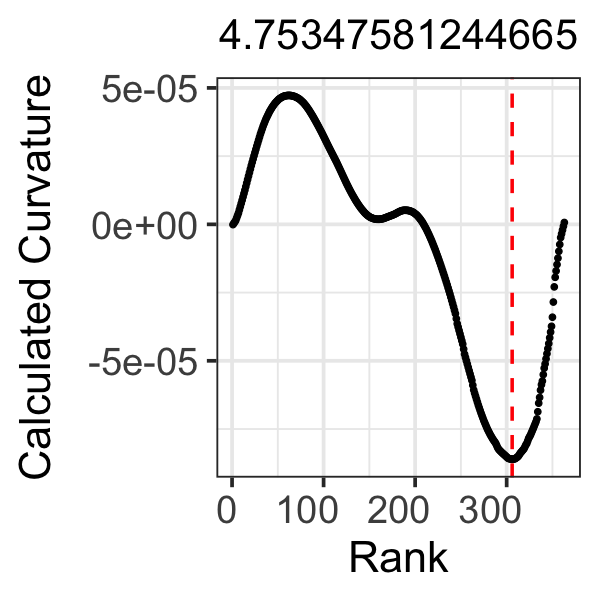

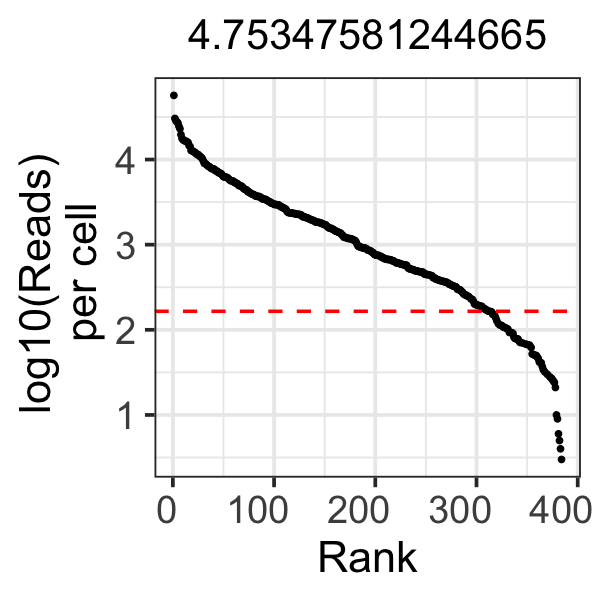

In [14]:
fig.size(5,5)
FBXO11_filtered <- Filtering_Cells_Read(alleles_DNA)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


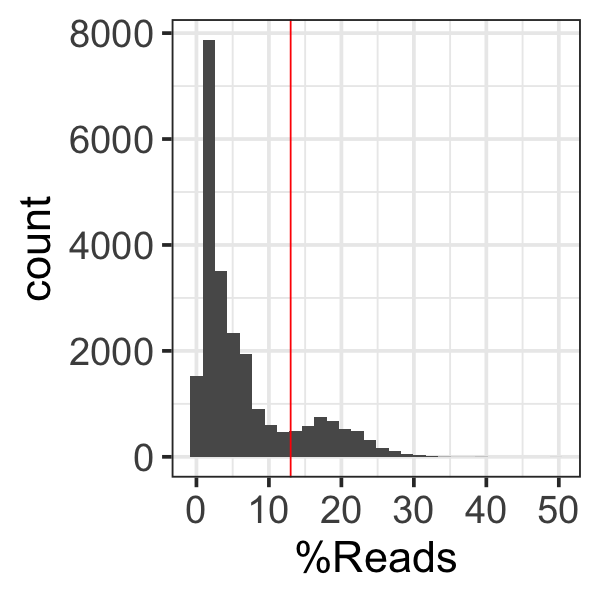

In [15]:
#Define a cutoff
FBXO11_filtered %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() + geom_vline(xintercept = 13, color = "red")

In [17]:
FBXO11_filtered <- FBXO11_filtered %>% Filtering_Alleles(cutoff=13)

In [18]:
#Fix reference
FBXO11_filtered <- mutate(FBXO11_filtered, Reference = "CAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTC")

In [19]:
#Trim all aligned alleles
FBXO11_filtered <- mutate(FBXO11_filtered, Aligned_Sequence = (str_sub(Aligned_Sequence, -63) %>% str_trunc(51, "right", ellipsis = "")))
FBXO11_filtered <- mutate(FBXO11_filtered, Reference = (str_sub(Reference, -63) %>% str_trunc(51, "right", ellipsis = "")))

In [20]:
## Remove alleles found in less than 5 cells. 
FBXO11_filtered <- FBXO11_filtered  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)

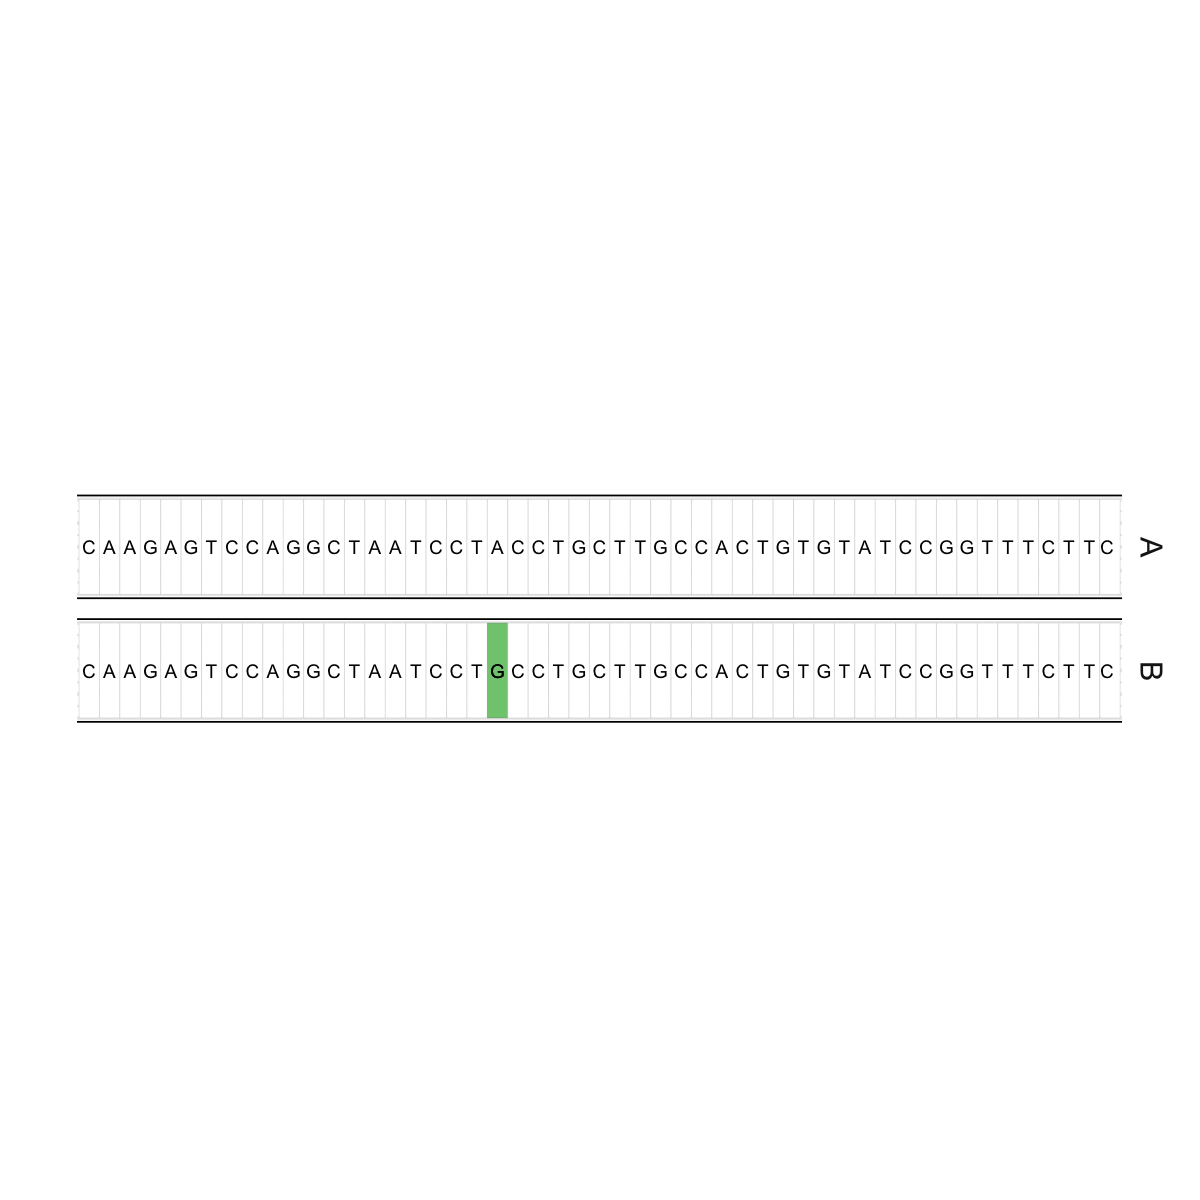

In [21]:
FBXO11_filtered %>% Plotting_Alleles # Plot

In [22]:
FBXO11_gen <- Genotyping_Cells(FBXO11_filtered) # calculate genotypes / Allele Freq

In [32]:
FBXO11_gen %>% write_csv("FBXO11_gen.csv") # Save for quick restarting

# RNASeq QC

In [306]:
nUMI = colSums(exprs)
nGenes = colSums(exprs > 0)
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

#meta = cbind(meta, qc_df[rownames(meta), ])

In [307]:
meta = cbind(meta, qc_df[rownames(meta), ])

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


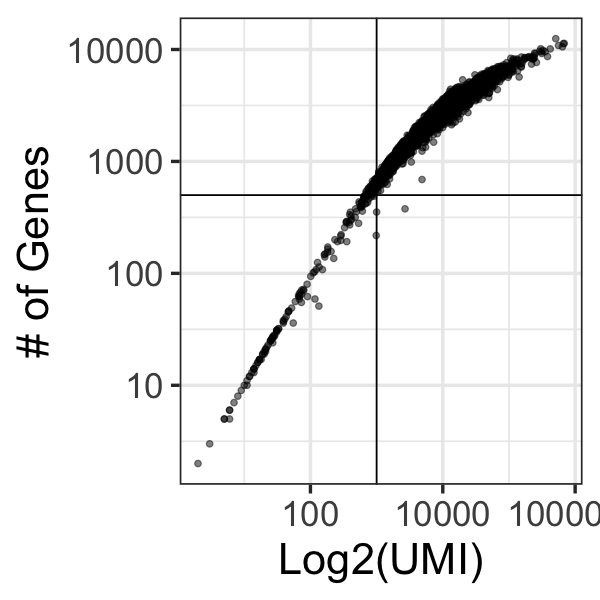

In [308]:
fig.size(5,5)
library(scales)
options(scipen = 999)

ggplot(qc_df %>% na.omit) +
    
    geom_point(aes(x=(nUMI), y=nGenes), alpha = 0.5) +
    theme_gy(21) + ylab("# of Genes") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2")  + 
    theme(legend.position = "none") + 
    scale_x_continuous(labels = scales::comma) + 
    labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) + 
    geom_vline(xintercept = (1000)) + 
    geom_hline(yintercept = 500) + scale_y_log10() + scale_x_log10() 
    

In [309]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

nUMI_thresh =  1000 #5000 #40
nGene_thresh = 500
pctMito_thresh = 0.1

ncell_thresh = floor(dim(exprs)[2]*0.1) #expressed in 10% of cells

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   rownames(qc_df %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh))]

filt_meta = meta[colnames(filt_exprs),]

In [38]:
writeMM(obj = exprs, "exprs.mtx")
write.csv(colnames(exprs), "colnames_exprs.csv")
write.csv(rownames(exprs), "rownames_exprs.csv")

NULL

In [39]:
writeMM(obj = filt_exprs, "FilteredGeneMatrix.mtx")
write.csv(colnames(filt_exprs), "filt_colnames_exprs.csv")
write.csv(rownames(filt_exprs), "filt_rownames_exprs.csv")
#filter on gene expression > 0 & perecent mito < 0.1 

NULL

# ADT QC

In [312]:
nUMI_ADT = colSums(counts_ADT_filt)
nGenes_ADT = colSums(counts_ADT_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

rownames(meta_ADT) <- meta_ADT$cell_adt
meta_ADT_filt = cbind(meta_ADT, qc_df_ADT[rownames(meta_ADT), ])

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


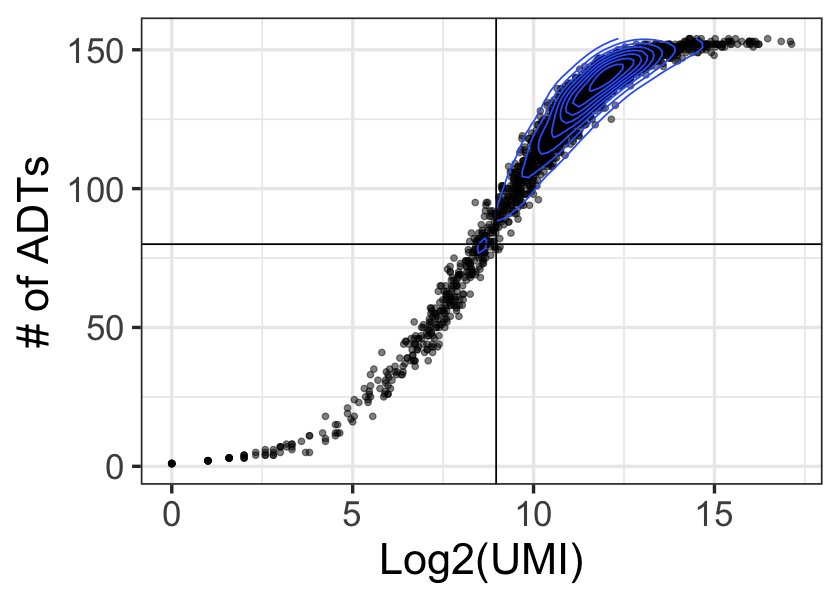

In [313]:
fig.size(5, 7)
ggplot(qc_df_ADT %>% na.omit) +
    geom_point(aes(x=log2(nUMI), y=nGenes), alpha = 0.5) + geom_density_2d(aes(x=log2(nUMI), y=nGenes))  + 
    theme_gy(21) + ylab("# of ADTs") + 
    xlab("Log2(UMI)") +
    theme(legend.position = "right") + 
 labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) +
  geom_vline(xintercept = log2(500))+
    geom_hline(yintercept = 80) 
    

In [316]:
# Filter to QC'd cells only
qc_df_ADT = qc_df_ADT %>% filter(nUMI > 500, nGenes > 80)
counts_ADT_filt = counts_ADT_filt[, rownames(qc_df_ADT)]


In [244]:
writeMM(obj = counts_ADT_filt, "FilteredADTMatrix.mtx")
write.csv(colnames(counts_ADT_filt), "filt_colnames_adt.csv")
write.csv(rownames(counts_ADT_filt), "filt_rownames_a.csv")
#filter on gene expression > 0 & perecent mito < 0.1 

NULL

# Clean up meta data

In [77]:
#Fix labels - cell_ids
FBXO11_gen <- FBXO11_gen %>% mutate(plate = sub("FBXO11(\\d+).*", "\\1", plate_well))
FBXO11_gen <- FBXO11_gen %>% mutate(Well_ID = sub(".*?(\\d+)([A-Z]\\d+).*", "\\2", FBXO11_gen$plate_well))

In [78]:
# merge cell barcodes
FBXO11_gen <- read_csv("RNA_ADT_Barcodes.csv") %>% inner_join(FBXO11_gen) %>% mutate(cell = paste0(RNA_cell, "_FBXO11_", plate))

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`


In [357]:
IndexFlow

well cellType  Experiment Plate extra sample SSC_A     CD45     
1    A1   FBXO11 KO FBXO11     1     DNA   S1     17703.00   38.19718
2    A2   FBXO11 KO FBXO11     1     DNA   S1     14138.09   32.63412
3    A3   NTC       FBXO11     1     DNA   S1     21192.00  378.55152
4    A4   FBXO11 KO FBXO11     1     DNA   S1     14138.09   19.89886
5    A5   FBXO11 KO FBXO11     1     DNA   S1     16180.22   26.65516
6    A6   FBXO11 KO FBXO11     1     DNA   S1     21673.92   29.16378
7    A7   FBXO11 KO FBXO11     1     DNA   S1     12634.63   34.13525
8    A8   FBXO11 KO FBXO11     1     DNA   S1     19369.10   19.02378
9    A9   NTC       FBXO11     1     DNA   S1     21192.00  302.32130
10   A10  NTC       FBXO11     1     DNA   S1     28387.36  309.19636
11   A11  FBXO11 KO FBXO11     1     DNA   S1     14788.42   35.70544
12   A12  NTC       FBXO11     1     DNA   S1     10090.35  122.98262
13   A13  FBXO11 KO FBXO11     1     DNA   S1     15124.73   23.82062
14   A14  FBXO11 KO FBXO11     1     DNA   S1     11810.43   16.62276
15   A15  FBXO11 KO FBXO11     1     DNA   S1     12634.63   22.77309
16   A16  NTC       FBXO11     1     DNA   S1     10090.35  157.49458
17   A17  FBXO11 KO FBXO11     1     DNA   S1     17703.00   36.51741
18   A18  FBXO11 KO FBXO11     1     DNA   S1     24804.54   42.74245
19   A19  FBXO11 KO FBXO11     1     DNA   S1     12079.01   65.52488
20   A20  NTC       FBXO11     1     DNA   S1     11291.05  206.27810
21   A21  NTC       FBXO11     1     DNA   S1     20720.79  395.96450
22   A22  NTC       FBXO11     1     DNA   S1     12921.95  215.76668
23   A23  NTC       FBXO11     1     DNA   S1     10090.35  180.24340
24   A24  NTC       FBXO11     1     DNA   S1     18105.58  197.20679
25   B1   FBXO11 KO FBXO11     1     DNA   S1     10554.50   83.91278
26   B2   NTC       FBXO11     1     DNA   S1     12353.70  120.24807
27   B3   FBXO11 KO FBXO11     1     DNA   S1     17703.00   41.79206
28   B4   FBXO11 KO FBXO11     1     DNA   S1     15124.73   37.34785
29   B5   NTC       FBXO11     1     DNA   S1     21192.00  484.78243
30   B6   NTC       FBXO11     1     DNA   S1     16924.49  542.46909
⋮    ⋮    ⋮         ⋮          ⋮     ⋮     ⋮      ⋮         ⋮        
2659 O19  FBXO11 KO FBXO11     8     DNA   S8     12921.952  85.82104
2660 O20  NTC       FBXO11     8     DNA   S8      9646.616 107.46078
2661 O21  FBXO11 KO FBXO11     8     DNA   S8     27138.994  17.78279
2662 O22  FBXO11 KO FBXO11     8     DNA   S8     18105.582  29.16378
2663 O23  FBXO11 KO FBXO11     8     DNA   S8     11810.428  24.91635
2664 O24  FBXO11 KO FBXO11     8     DNA   S8     11547.820  18.18719
2665 P1   FBXO11 KO FBXO11     8     DNA   S8     11291.051  48.91625
2666 P2   NTC       FBXO11     8     DNA   S8     11547.820 206.27810
2667 P3   FBXO11 KO FBXO11     8     DNA   S8     12353.695  28.51531
2668 P4   FBXO11 KO FBXO11     8     DNA   S8     20260.055  57.25488
2669 P5   NTC       FBXO11     8     DNA   S8     11291.051 215.76668
2670 P6   FBXO11 KO FBXO11     8     DNA   S8     18517.320  42.74245
2671 P7   NTC       FBXO11     8     DNA   S8     20720.787 241.44182
2672 P8   FBXO11 KO FBXO11     8     DNA   S8     22166.806  36.51741
2673 P9   FBXO11 KO FBXO11     8     DNA   S8      9646.616  17.00078
2674 P10  NTC       FBXO11     8     DNA   S8     10794.515 107.46078
2675 P11  FBXO11 KO FBXO11     8     DNA   S8     16180.218  24.36233
2676 P12  FBXO11 KO FBXO11     8     DNA   S8     12353.695  15.53840
2677 P13  NTC       FBXO11     8     DNA   S8     17309.370 153.99265
2678 P14  NTC       FBXO11     8     DNA   S8     12353.695 316.22777
2679 P15  FBXO11 KO FBXO11     8     DNA   S8     13823.722  76.69475
2680 P16  FBXO11 KO FBXO11     8     DNA   S8     14459.599  26.65516
2681 P17  FBXO11 KO FBXO11     8     DNA   S8     17309.370  14.52477
2682 P18  FBXO11 KO FBXO11     8     DNA   S8     23713.737  32.63412
2683 P19  NTC       FBXO11     8     DNA   S8     14788.423 241.44182
2684 P20  FBXO1

In [364]:
IndexFlow %>% head

well cellType  Experiment Plate extra sample SSC_A    CD45      CD40     
1 A1   FBXO11 KO FBXO11     1     DNA   S1     17703.00  38.19718  71.69168
2 A2   FBXO11 KO FBXO11     1     DNA   S1     14138.09  32.63412 246.93243
3 A3   NTC       FBXO11     1     DNA   S1     21192.00 378.55152 649.38163
4 A4   FBXO11 KO FBXO11     1     DNA   S1     14138.09  19.89886  45.72527
5 A5   FBXO11 KO FBXO11     1     DNA   S1     16180.22  26.65516 225.69172
6 A6   FBXO11 KO FBXO11     1     DNA   S1     21673.92  29.16378  85.82104
  bc         cellTypeNew plate_well
1 AACACGAGGA Edited      FBXO111A1 
2 AACCAATGAC Edited      FBXO111A2 
3 AACGACTCCA NTC         FBXO111A3 
4 AACGTATACC Edited      FBXO111A4 
5 AACGTTGCAG Edited      FBXO111A5 
6 AAGACAAGTC Edited      FBXO111A6

In [370]:
IndexFlow %>% dplyr::rename(Well_ID = well) %>% inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% mutate(cell = paste0(RNA_cell, "_",Experiment,"_",Plate)) %>% 
inner_join(filt_meta)

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(cell)`


Well_ID cellType  Experiment Plate extra sample SSC_A     CD45     
1    A1      FBXO11 KO FBXO11     1     DNA   S1     17703.00   38.19718
2    A2      FBXO11 KO FBXO11     1     DNA   S1     14138.09   32.63412
3    A3      NTC       FBXO11     1     DNA   S1     21192.00  378.55152
4    A4      FBXO11 KO FBXO11     1     DNA   S1     14138.09   19.89886
5    A5      FBXO11 KO FBXO11     1     DNA   S1     16180.22   26.65516
6    A6      FBXO11 KO FBXO11     1     DNA   S1     21673.92   29.16378
7    A7      FBXO11 KO FBXO11     1     DNA   S1     12634.63   34.13525
8    A8      FBXO11 KO FBXO11     1     DNA   S1     19369.10   19.02378
9    A9      NTC       FBXO11     1     DNA   S1     21192.00  302.32130
10   A10     NTC       FBXO11     1     DNA   S1     28387.36  309.19636
11   A11     FBXO11 KO FBXO11     1     DNA   S1     14788.42   35.70544
12   A12     NTC       FBXO11     1     DNA   S1     10090.35  122.98262
13   A13     FBXO11 KO FBXO11     1     DNA   S1     15124.73   23.82062
14   A14     FBXO11 KO FBXO11     1     DNA   S1     11810.43   16.62276
15   A15     FBXO11 KO FBXO11     1     DNA   S1     12634.63   22.77309
16   A16     NTC       FBXO11     1     DNA   S1     10090.35  157.49458
17   A18     FBXO11 KO FBXO11     1     DNA   S1     24804.54   42.74245
18   A20     NTC       FBXO11     1     DNA   S1     11291.05  206.27810
19   A21     NTC       FBXO11     1     DNA   S1     20720.79  395.96450
20   A22     NTC       FBXO11     1     DNA   S1     12921.95  215.76668
21   A23     NTC       FBXO11     1     DNA   S1     10090.35  180.24340
22   A24     NTC       FBXO11     1     DNA   S1     18105.58  197.20679
23   B1      FBXO11 KO FBXO11     1     DNA   S1     10554.50   83.91278
24   B2      NTC       FBXO11     1     DNA   S1     12353.70  120.24807
25   B3      FBXO11 KO FBXO11     1     DNA   S1     17703.00   41.79206
26   B4      FBXO11 KO FBXO11     1     DNA   S1     15124.73   37.34785
27   B5      NTC       FBXO11     1     DNA   S1     21192.00  484.78243
28   B6      NTC       FBXO11     1     DNA   S1     16924.49  542.46909
29   B7      FBXO11 KO FBXO11     1     DNA   S1     16180.22   19.02378
30   B8      NTC       FBXO11     1     DNA   S1     19369.10  270.17218
⋮    ⋮       ⋮         ⋮          ⋮     ⋮     ⋮      ⋮         ⋮        
2517 O19     FBXO11 KO FBXO11     8     DNA   S8     12921.952  85.82104
2518 O20     NTC       FBXO11     8     DNA   S8      9646.616 107.46078
2519 O21     FBXO11 KO FBXO11     8     DNA   S8     27138.994  17.78279
2520 O22     FBXO11 KO FBXO11     8     DNA   S8     18105.582  29.16378
2521 O23     FBXO11 KO FBXO11     8     DNA   S8     11810.428  24.91635
2522 O24     FBXO11 KO FBXO11     8     DNA   S8     11547.820  18.18719
2523 P1      FBXO11 KO FBXO11     8     DNA   S8     11291.051  48.91625
2524 P2      NTC       FBXO11     8     DNA   S8     11547.820 206.27810
2525 P3      FBXO11 KO FBXO11     8     DNA   S8     12353.695  28.51531
2526 P4      FBXO11 KO FBXO11     8     DNA   S8     20260.055  57.25488
2527 P5      NTC       FBXO11     8     DNA   S8     11291.051 215.76668
2528 P6      FBXO11 KO FBXO11     8     DNA   S8     18517.320  42.74245
2529 P7      NTC       FBXO11     8     DNA   S8     20720.787 241.44182
2530 P8      FBXO11 KO FBXO11     8     DNA   S8     22166.806  36.51741
2531 P9      FBXO11 KO FBXO11     8     DNA   S8      9646.616  17.00078
2532 P10     NTC       FBXO11     8     DNA   S8     10794.515 107.46078
2533 P11     FBXO11 KO FBXO11     8     DNA   S8     16180.218  24.36233
2534 P12     FBXO11 KO FBXO11     8     DNA   S8     12353.695  15.53840
2535 P13     NTC       FBXO11     8     DNA   S8     17309.370 153.99265
2536 P14     NTC       FBXO11     8     DNA   S8     12353.695 316.22777
2537 P15     FBXO11 KO FBXO11     8     DNA   S8     13823.722  76.69475
2538 P16     FBXO11 KO FBXO11     8     DNA   S8     14459.599  26.65516
2539 P17     FBXO11 KO FBXO11     8     DNA   S8     17309.370 

In [395]:
#Merge modalities
FBXO11_plots <- 
IndexFlow %>% rename(Plate = "plate") %>% select(-extra, -sample) %>% rename(well = "Well_ID") %>% 
inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% mutate(cell = paste0(RNA_cell, "_",Experiment,"_",plate)) %>% 
inner_join(select(filt_meta, - plate)) %>%
inner_join(FBXO11_gen) %>% 
inner_join(rename(meta_ADT_filt, cell_adt = "cell") %>% select(-plate), by = "cell")

Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(cell)`
Joining with `by = join_by(plate_well)`


## Joint Analysis Run 1 and Run 2 (even though Run 2 had terrible FBXO11) expression. 

In [25]:
FBXO11_plots<-read_csv("FBXO11plots.csv")

Rows: 1744 Columns: 65
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): cell, Well_ID, cellType, bc, cellTypeNew, RNA_cell, plate_well, ge...
dbl (56): plate.x, nUMI.x, nGenes.x, pctMito, UMAP1.x, UMAP2.x, PC1.x, PC2.x...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [396]:
#Combined meta data
#CleanUp
Run2_meta<- FBXO11_plots

In [399]:
Run2_meta <- select(Run2_meta, cell, plate, nUMI.x, nGenes.x, pctMito, cellType, genotype, AllelicGenotype, nUMI.y, nGenes.y)

In [28]:
Run1_meta <- read_csv("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/FBXO11plots_Updated.csv")

Rows: 1034 Columns: 36
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (20): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (16): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [404]:
## merge meta data 
Run1_meta <- 
read_csv("..//2023-04-03 PTEN-DQB1-FBXO11/Analysis/meta.csv") %>% select(cell, nUMI, nGenes, pctMito) %>% 
inner_join(by= "cell",
    read_csv("..//2023-04-03 PTEN-DQB1-FBXO11/Analysis/meta_adt.csv") %>% select(cell, nUMI, nGenes)) %>% inner_join(Run1_meta)

Rows: 4607 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): plate, cell, Condition, MainCondition, ADT, cell_ADT
dbl (3): nUMI, nGenes, pctMito

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4139 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): plate, cell_adt, Condition, MainCondition, RNA, cell
dbl (2): nUMI, nGenes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell, nUMI.x, nGenes.x, pctMito, nUMI.y, nGenes.y)`


In [407]:
Run1_meta <- select(Run1_meta, cell, Plate, nUMI.x, nGenes.x, pctMito, Edited, genotype, AllelicGenotype, nUMI.y, nGenes.y)

In [408]:
colnames(Run1_meta) <- c("cell", "Plate", "nUMI_RNA", "nGenes", "pctMito", "Edited", "genotype", "AllelicGenotype", "nUMI_ADT", "nADTs")

In [409]:
colnames(Run2_meta) <- c("cell", "Plate", "nUMI_RNA", "nGenes", "pctMito", "Edited", "genotype", "AllelicGenotype", "nUMI_ADT", "nADTs")

In [410]:
meta_FBXO11<- rbind(mutate(Run1_meta, Run = "1"), 
      mutate(Run2_meta, Run = "2"))

In [163]:
write_csv(meta_FBXO11, "meta_FBXO11.csv") # for later restarting

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [6]:
read_csv("meta_FBXO11.csv") %>% colnames

Rows: 2778 Columns: 17
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): cell, Plate, Edited, genotype, AllelicGenotype
dbl (12): nUMI_RNA, nGenes, pctMito, UMAP1_RNA, UMAP2_RNA, cluster_RNA, nUMI...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "cell"            "Plate"           "nUMI_RNA"        "nGenes"         
 [5] "pctMito"         "UMAP1_RNA"       "UMAP2_RNA"       "cluster_RNA"    
 [9] "Edited"          "genotype"        "AllelicGenotype" "nUMI_ADT"       
[13] "nADTs"           "UMAP1_ADT"       "UMAP2_ADT"       "cluster_ADT"    
[17] "Run"

# Join expression. 

In [411]:
Run1exprs <- readMM("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/FilteredGeneMatrix.mtx")
colnames(Run1exprs) <- read.csv("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/filt_colnames_exprs.csv")[,2]
rownames(Run1exprs) <- read.csv("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/filt_rownames_exprs.csv")[,2]

Run1counts_adt <- readMM("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/FilteredADTmatrix.mtx")
colnames(Run1counts_adt) <- read.csv("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/filt_colnames_ADT.csv")[,2]
rownames(Run1counts_adt) <- read.csv("../2023-04-03 PTEN-DQB1-FBXO11/Analysis/filt_rownames_ADT.csv")[,2]

Run2exprs <- readMM("FilteredGeneMatrix.mtx")
colnames(Run2exprs) <- read.csv("filt_colnames_exprs.csv")[,2]
rownames(Run2exprs) <- read.csv("filt_rownames_exprs.csv")[,2]

Run2counts_adt <- readMM("FilteredADTMatrix.mtx")
colnames(Run2counts_adt) <- read.csv("filt_colnames_adt.csv")[,2]
rownames(Run2counts_adt) <- read.csv("filt_rownames_adt.csv")[,2]


In [35]:
Run1exprs <- Run1exprs[,colnames(Run1exprs) %in% meta_FBXO11$cell]
Run2exprs <- Run2exprs[,colnames(Run2exprs) %in% meta_FBXO11$cell]

In [36]:
Run1counts_adt <- Run1counts_adt[,colnames(Run1counts_adt) %in% meta_FBXO11$cell]
Run2counts_adt <- Run2counts_adt[,colnames(Run2counts_adt) %in% meta_FBXO11$cell]

## RNA QC

In [37]:
nUMI = colSums(Run1exprs)
nGenes = colSums(Run1exprs > 0)
pctMito = colSums(Run1exprs[rownames(Run1exprs)[rownames(Run1exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run1exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [38]:
Run1exprs <- Run1exprs[nCells > 0.1 *dim(Run1exprs)[2],] #filter on at least 10% expression

In [39]:
# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run2exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [40]:
Run2exprs <- Run2exprs[nCells > 0.1 *dim(Run2exprs)[2],]#filter on at least 10% expression

In [41]:
#Merge two matrices
sharedgenes <- rownames(Run1exprs) %>% intersect(rownames(Run2exprs))

#Bind together
full_exprs <- cbind(Run1exprs[sharedgenes,], Run2exprs[sharedgenes,])

In [42]:
full_exprs %>% dim

[1] 7264 2778

In [43]:
#fix rownames
rownames(meta_FBXO11) <- meta_FBXO11$cell

Warning message:
“Setting row names on a tibble is deprecated.”


In [45]:
#Scale expression
scale_exprs = process_rna(as.matrix(full_exprs), meta_FBXO11, topn = 3000)

# Dimensionality Reduction

In [47]:
set.seed(seed = 120)
meta_FBXO11$Run <- as.factor(meta_FBXO11$Run)

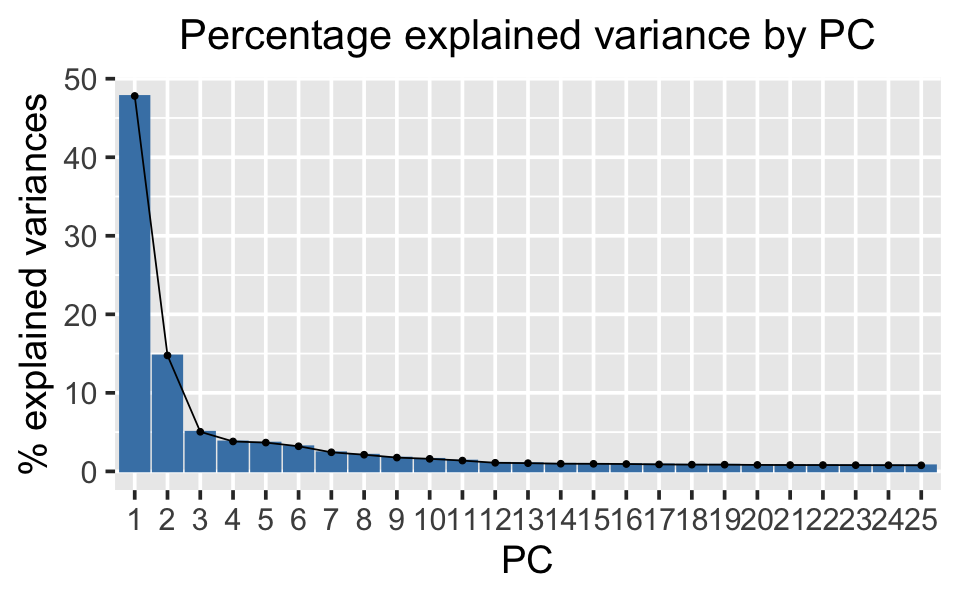

In [48]:
pca_res = prcomp_irlba(scale_exprs %>% t, 25)
rownames(pca_res$x) = colnames(scale_exprs)
rownames(pca_res$rotation) = rownames(scale_exprs)
pcs = pca_res$x
fig.size(5, 8)
p = fviz_screeplot(pca_res, ncp = 25) + theme_g() + ggtitle("Percentage explained variance by PC") + 
        xlab("PC") + ylab("% explained variances")
print(p)
    

In [49]:
meta_FBXO11$Plate <- as.factor(meta_FBXO11$Plate)


Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.harmony is replaced with parameter max_iter. It will be ignored for this function call and please use parameter max_iter in future function calls.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter max.iter.cluster is deprecated. It will be ignored for this function call and please remove parameter max.iter.cluster in future function calls. Advanced users can set value of parameter max.iter.cluster by using parameter .options and function harmony_options().
This warning is displayed o

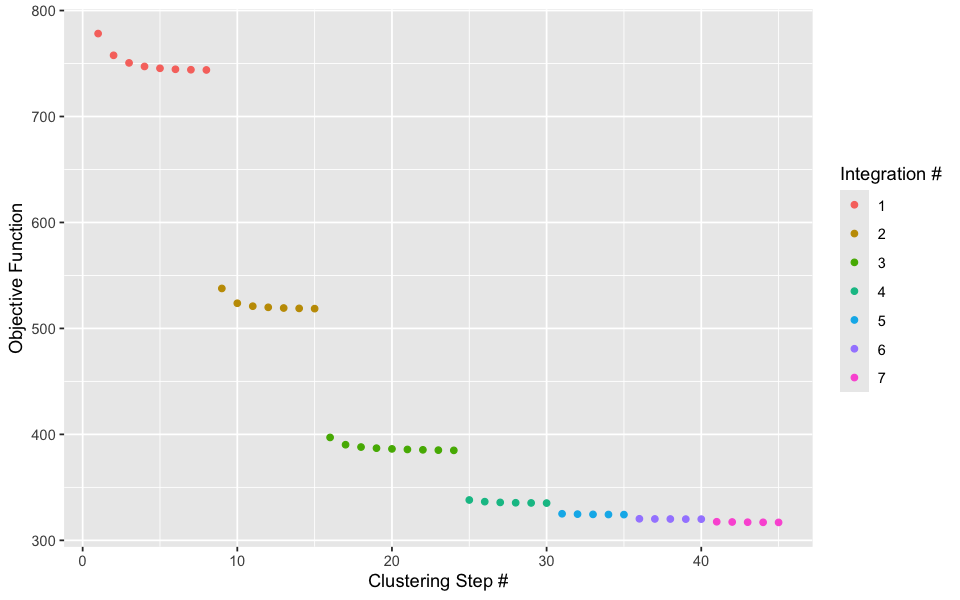

In [50]:
rownames(meta_FBXO11) <- meta_FBXO11$cell
umap_input <- HarmonyMatrix(pcs[, 1:10], meta_FBXO11[rownames(pcs),], 
            c("Plate", "Run"), 
            plot_convergence = TRUE, max.iter.harmony = 10, epsilon.cluster = -Inf, 
            epsilon.harmony = -Inf, max.iter.cluster = 10, do_pca = F, 
            verbose = F)
umap_res = umap(umap_input)
umap_df = data.frame(umap_res)
colnames(umap_df) = c("UMAP1", "UMAP2")
meta_umap = cbind(meta_FBXO11[rownames(umap_df), ], umap_df, umap_input[rownames(umap_df), 
        ])

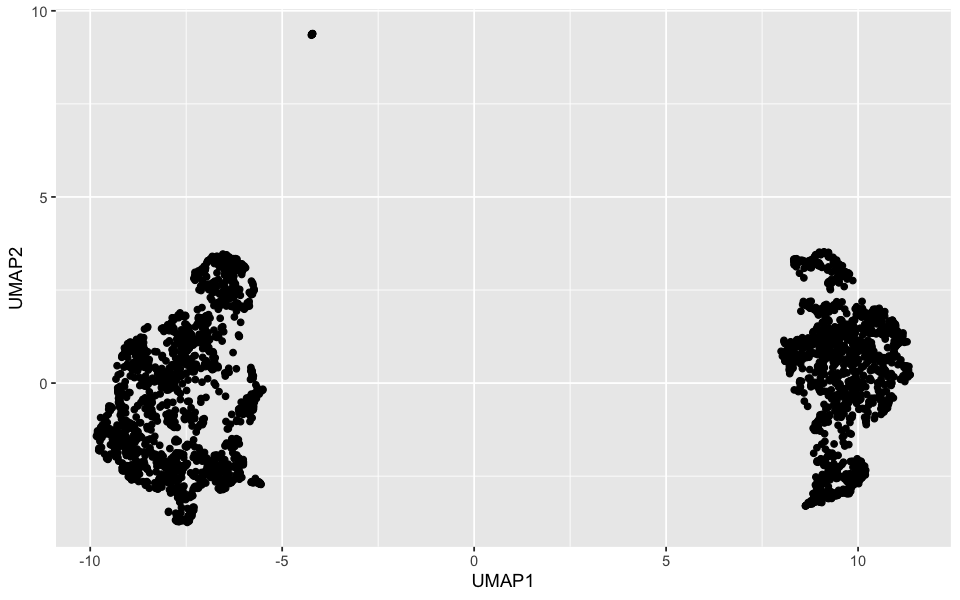

In [51]:
meta_umap %>% ggplot(aes(UMAP1, UMAP2)) + geom_point()

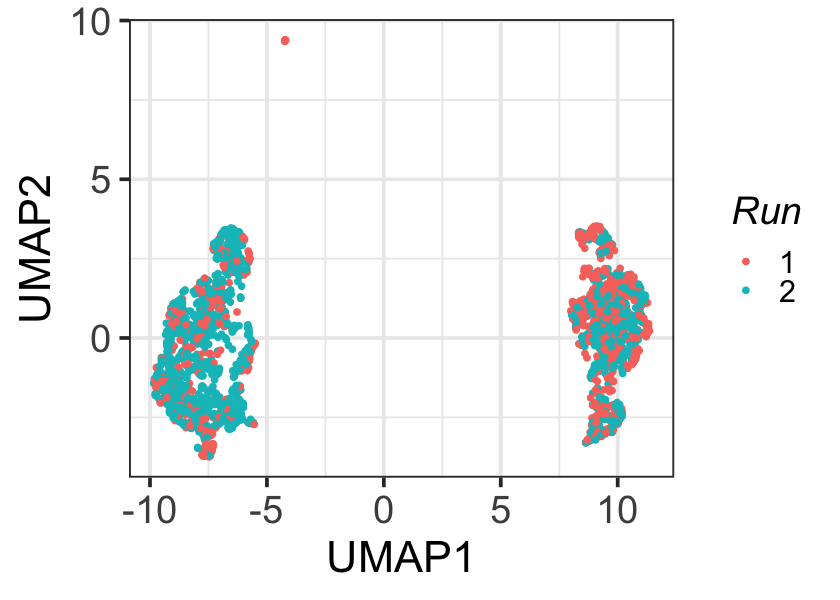

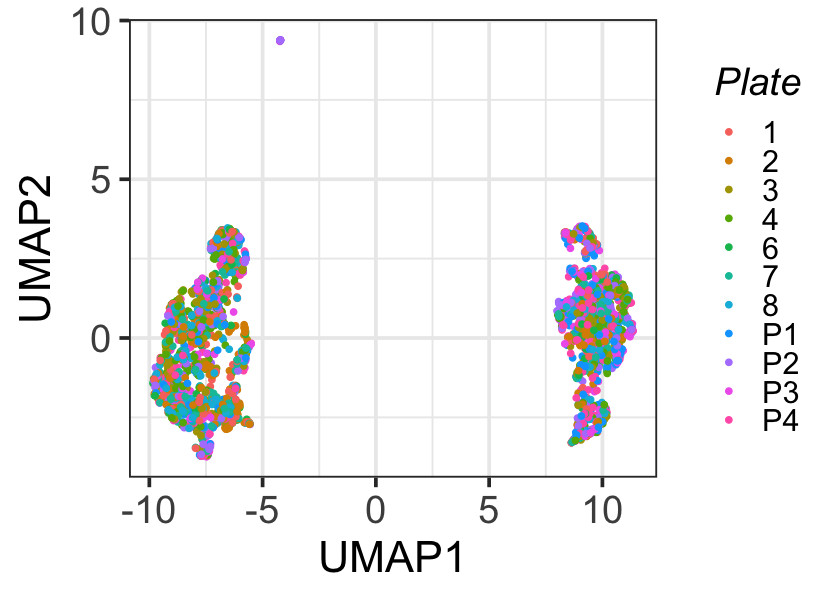

In [52]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Run))+
    theme_gy()

fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Plate))+
    theme_gy()

In [53]:
# Joint RNA
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 97834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9501
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 97834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9103
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 97834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8821
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 97834

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8573
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer ver

In [412]:
table(meta_umap.clust$'res.0.1')


   0    1    2 
1541 1222   15 

In [63]:

meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

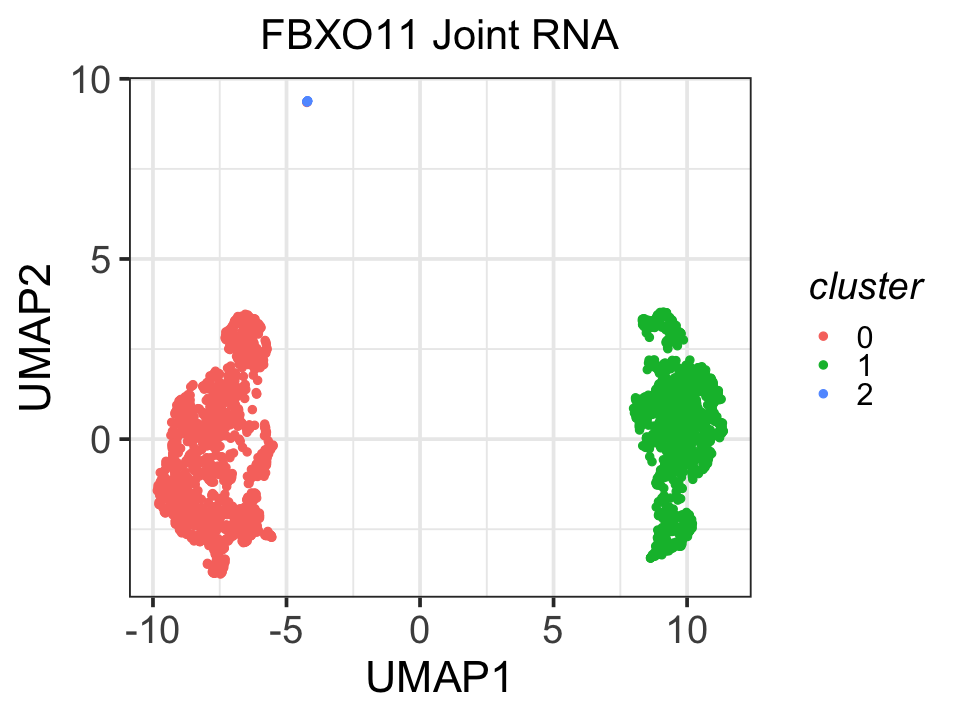

In [64]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    ggtitle('FBXO11 Joint RNA') + theme_gy()

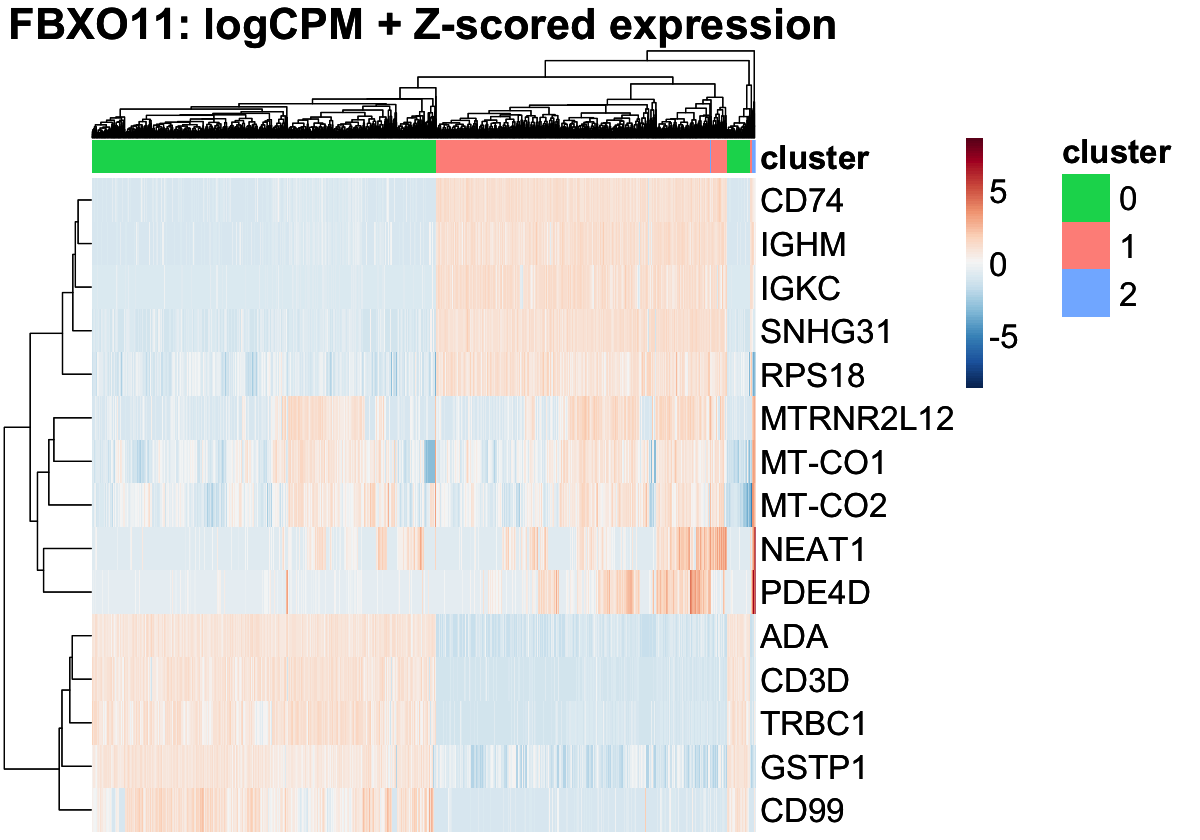

In [65]:
dge_DQB1 = wilcoxauc(scale_exprs, meta_umap.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap.clust$cluster)
rownames(mat_col) <- rownames(meta_umap.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs[var_genes_DQB1, ])))
fig.size(7, 10)
g <- pheatmap(scale_exprs[c(var_genes_DQB1), ],
         main = 'FBXO11: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )
g

# ADTs

In [70]:
#Merge two matrices
sharedadt <- rownames(Run1counts_adt) %>% intersect(rownames(Run2counts_adt))

#Bind together
full_adt <- cbind(Run1counts_adt[sharedadt,], Run2counts_adt[sharedadt,])

In [71]:
scale_adt <- process_adt(full_adt, meta_FBXO11)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



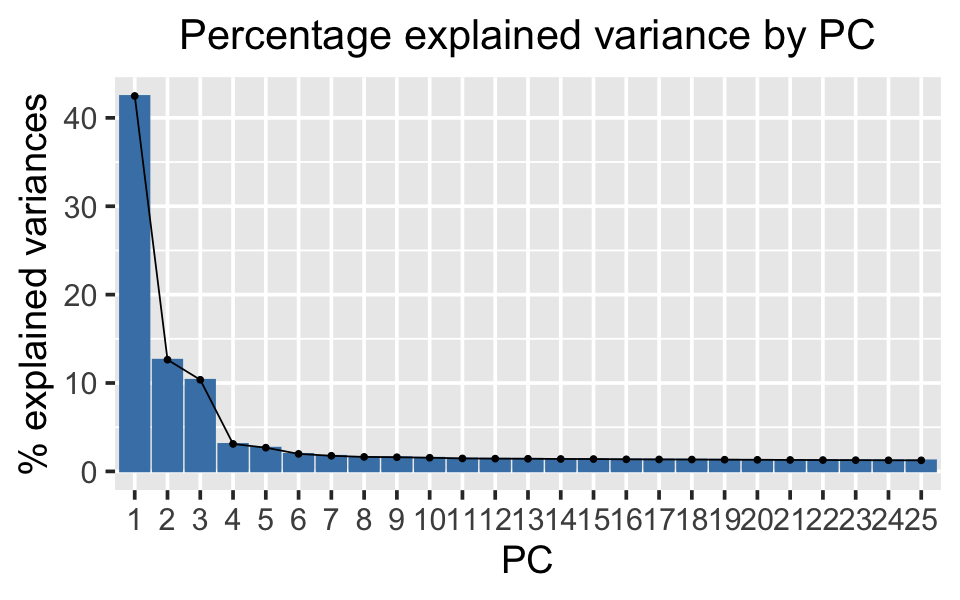

In [72]:
pca_res = prcomp_irlba(scale_adt %>% t, 25)
rownames(pca_res$x) = colnames(scale_adt)
rownames(pca_res$rotation) = rownames(scale_adt)
pcs = pca_res$x
fig.size(5, 8)
p = fviz_screeplot(pca_res, ncp = 25) + theme_g() + ggtitle("Percentage explained variance by PC") + 
        xlab("PC") + ylab("% explained variances")
print(p)
    

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



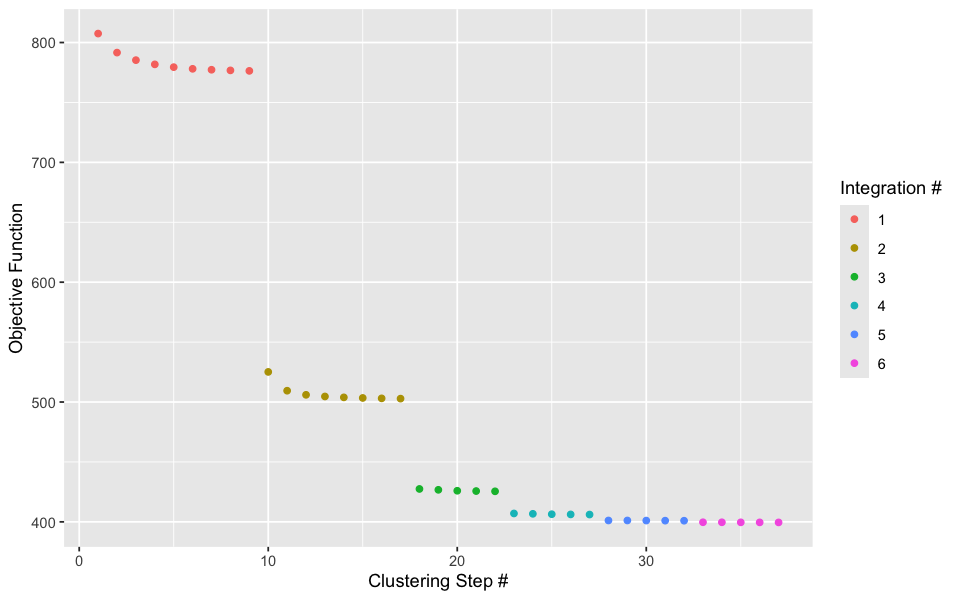

In [73]:
umap_input <- HarmonyMatrix(pcs[, 1:10], meta_FBXO11[rownames(pcs),], 
            c("Plate", "Run"), 
            plot_convergence = TRUE, max.iter.harmony = 10, epsilon.cluster = -Inf, 
            epsilon.harmony = -Inf, max.iter.cluster = 10, do_pca = F, 
            verbose = F)
umap_res = umap(umap_input)
umap_df = data.frame(umap_res)
colnames(umap_df) = c("UMAP1", "UMAP2")
meta_umap_adt = cbind(meta_FBXO11[rownames(umap_df), ], umap_df, umap_input[rownames(umap_df), 
        ])

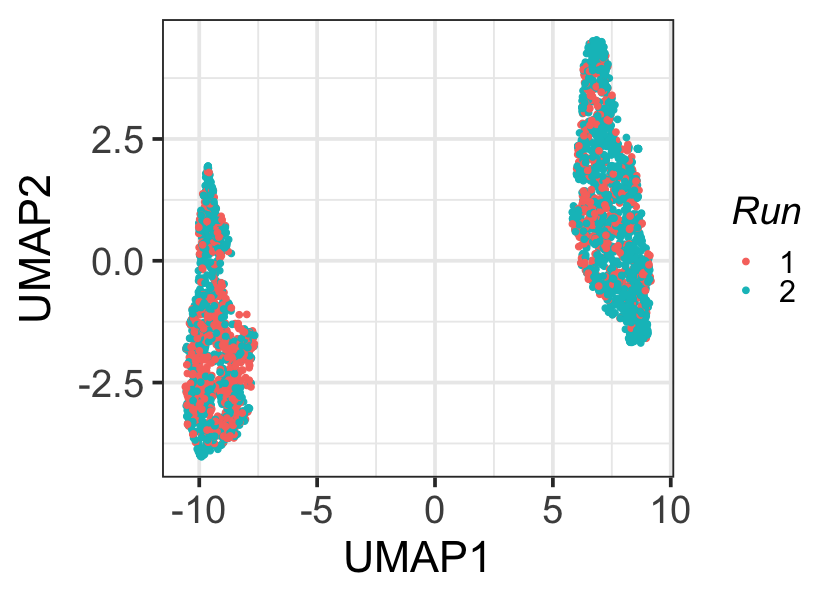

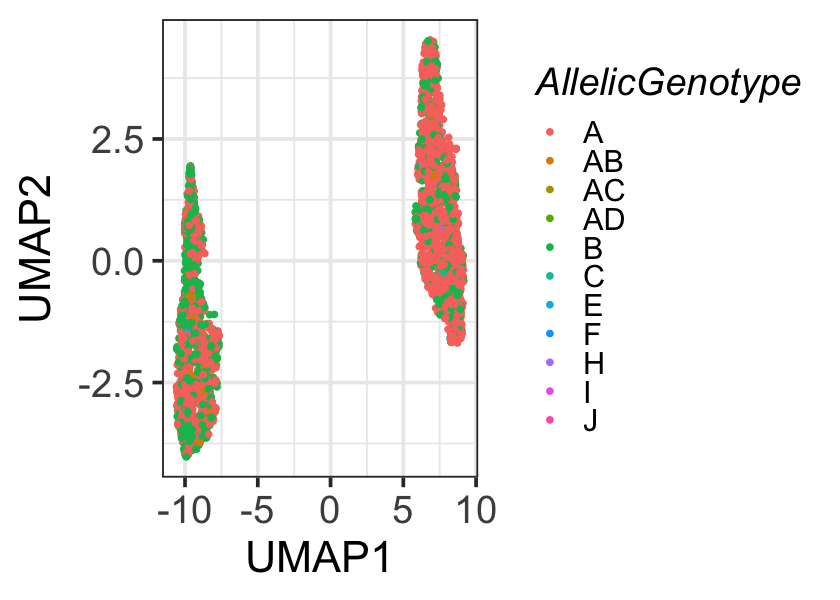

In [74]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Run))+
    theme_gy()

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = AllelicGenotype))+
    theme_gy()

In [75]:
# Joint ADT
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 101975

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9499
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 101975

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8997
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 101975

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8605
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2778
Number of edges: 101975

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8313
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer

In [76]:
#Define rough clustering
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

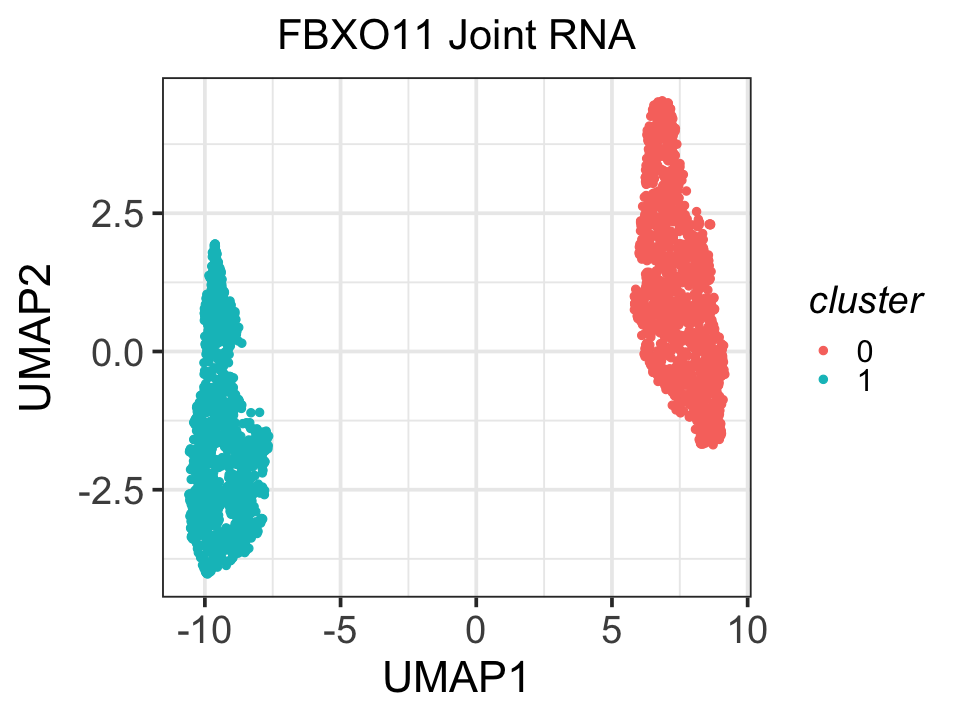

In [78]:
fig.size(6, 8)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    ggtitle('FBXO11 Joint RNA') + theme_gy()

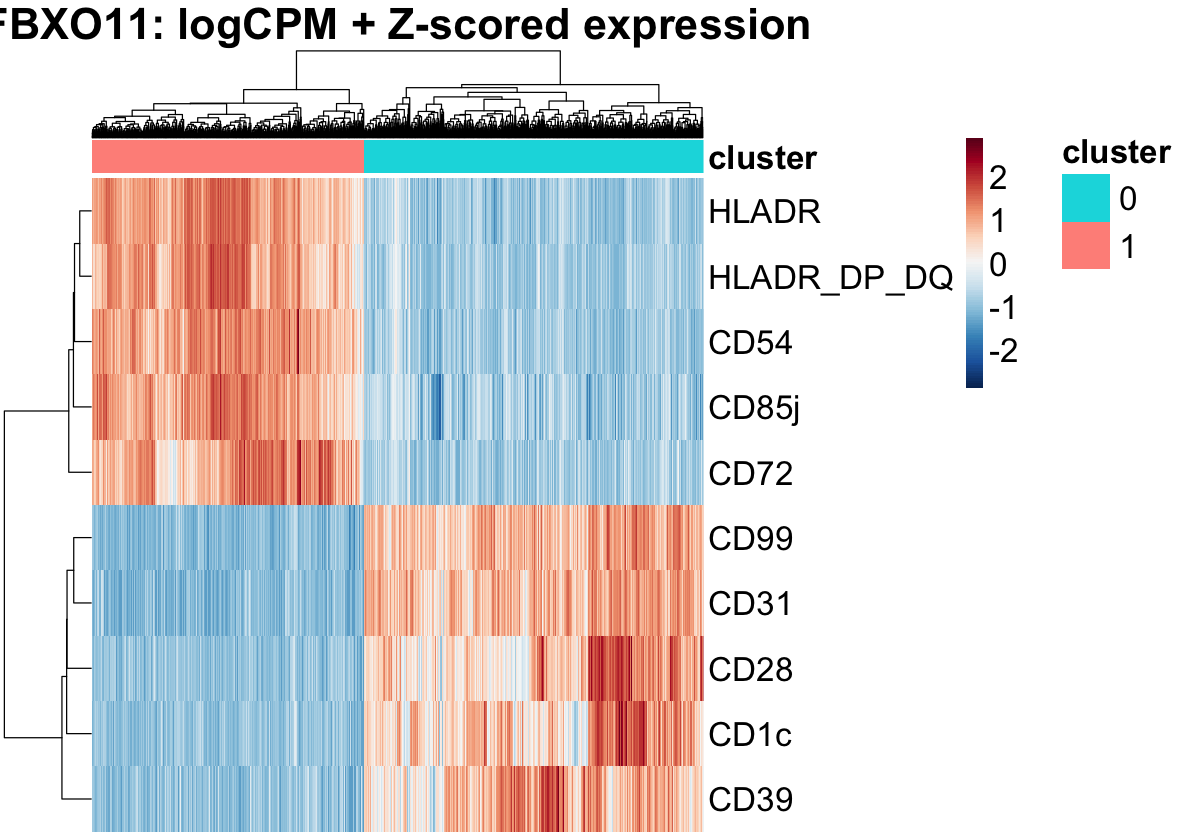

In [79]:
#Heatmap
dge_DQB1 = wilcoxauc(scale_adt, meta_umap_adt.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt[var_genes_DQB1, ])))
fig.size(7, 10)
g <- pheatmap(scale_adt[c(var_genes_DQB1), ],
         main = 'FBXO11: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

# Fix dosage for modeling

In [81]:

meta_umap.clust <- meta_umap.clust %>% mutate(Dosage = ifelse(AllelicGenotype == "A" & Run == 1, 2, 
                                    ifelse(AllelicGenotype == "AB" & Run == 1, 1,
                                           ifelse(AllelicGenotype == "B" & Run == 1, 0, 
                                    ifelse(AllelicGenotype == "A" & Run == 2, 0, 
                                    ifelse(AllelicGenotype == "AB" & Run == 2, 1,
                                           ifelse(AllelicGenotype == "B" & Run == 2, 2, NA))))))) 

In [82]:
meta_umap.clust <- meta_umap.clust %>% mutate(Edited = ifelse(Edited == "FBXO11 KO", "Edited", 
                                                  ifelse(Edited == "NTC", "Control", Edited)))

In [698]:
meta_umap.clust %>% write_csv("joint_meta_umap.csv")

In [9]:
meta_umap.clust <- read_csv("joint_meta_umap.csv")

Rows: 2778 Columns: 41
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): cell, Plate, Edited, genotype, AllelicGenotype
dbl (36): nUMI_RNA, nGenes, pctMito, UMAP1_RNA, UMAP2_RNA, cluster_RNA, nUMI...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
meta_umap.clust %>% colnames

[1] "cell"            "Plate"           "nUMI_RNA"        "nGenes"         
 [5] "pctMito"         "UMAP1_RNA"       "UMAP2_RNA"       "cluster_RNA"    
 [9] "Edited"          "genotype"        "AllelicGenotype" "nUMI_ADT"       
[13] "nADTs"           "UMAP1_ADT"       "UMAP2_ADT"       "cluster_ADT"    
[17] "Run"             "UMAP1"           "UMAP2"           "PC1"            
[21] "PC2"             "PC3"             "PC4"             "PC5"            
[25] "PC6"             "PC7"             "PC8"             "PC9"            
[29] "PC10"            "res.0.1"         "res.0.2"         "res.0.3"        
[33] "res.0.4"         "res.0.5"         "res.0.6"         "res.0.7"        
[37] "res.0.8"         "res.0.9"         "res.1"           "cluster"        
[41] "Dosage"

In [13]:
meta_umap.clust %>% select(cell, Plate, nUMI_RNA, nGenes, cluster_RNA, nUMI_ADT, nADTs, Edited, 
                           AllelicGenotype, Dosage) %>% 
write_csv("FBXO11meta.csv")

# Genotype Dependent Modeling

## Genotype Analysis

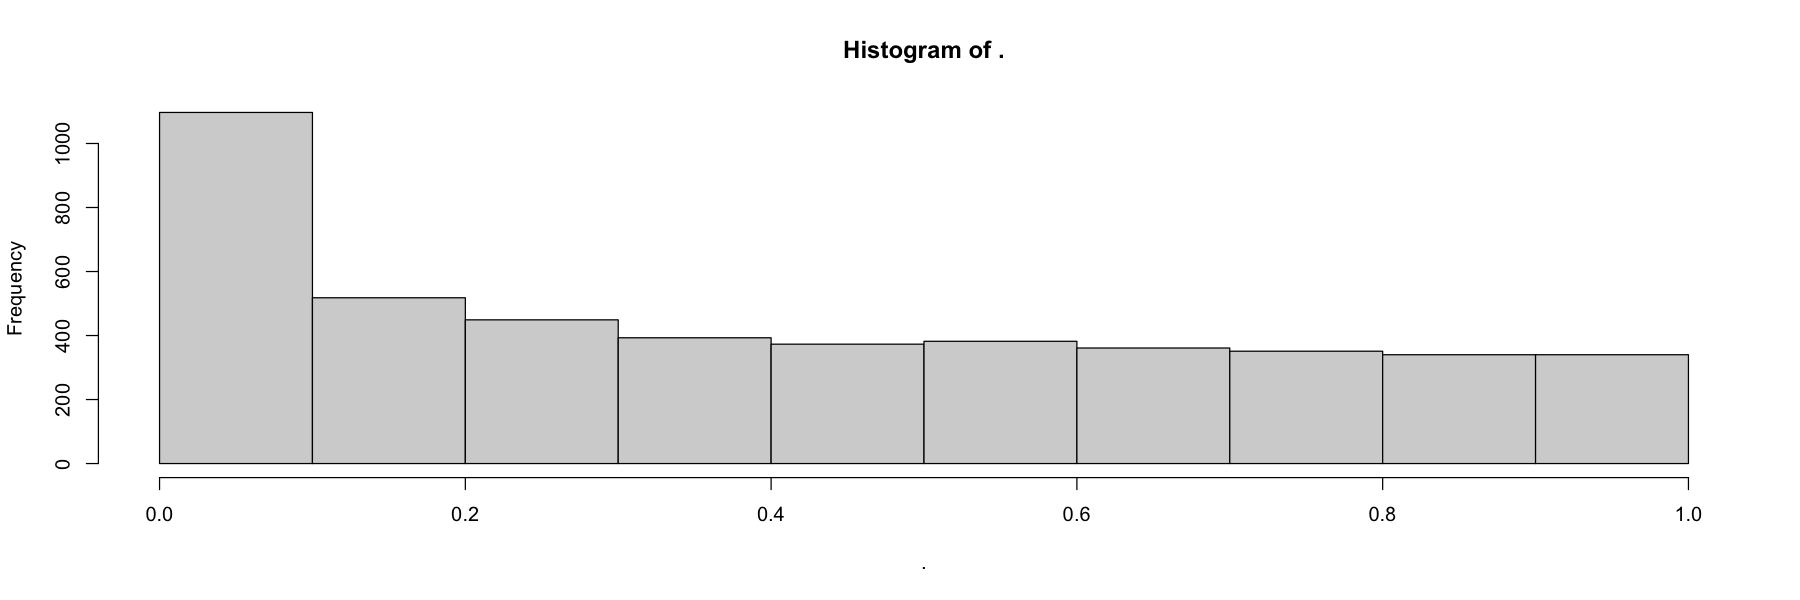

In [697]:
## Linear modeling with negative binomial. 
## Looking at Daudis only and removing control cells. 

df <- na.omit(meta_umap.clust %>% filter(cluster == 1 & Edited == "Edited"))
cells <- df %>% with(cell) #Daudis - CRISPR

nCells = rowSums(full_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 30% of cells
Exprs <- full_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]

suppressWarnings({
FBXO11_lm_Daudi <- 
    sapply(rownames(Exprs), function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_RNA) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_RNA) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1,)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi<- FBXO11_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi %>% with(pval) %>% hist
FBXO11_lm_Daudi <- FBXO11_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [700]:
FBXO11_lm_Daudi %>% write_csv("joint_FBXO11_lm.csv") # Save for later

## Condition Analysis

In [151]:
## Linear modeling with negative binomial. 
## Looking at Daudis only and removing control cells. 

df <- na.omit(meta_umap.clust %>% filter(cluster == 0 & Edited == "Edited"))
cells <- df %>% with(cell) #Daudis - CRISPR

nCells = rowSums(full_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 30% of cells
Exprs <- full_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]

suppressWarnings({
FBXO11_lm_Daudi_Edited <- 
    sapply(rownames(Exprs), function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_RNA) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_RNA) + Plate + Edited
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_Edited<- FBXO11_lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_Edited <- FBXO11_lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [704]:
FBXO11_lm_Daudi_Edited %>% filter(padj < 0.05)

Genes    pval                   beta        padj                
1   PDIA6    0.00000000000000000000 -0.5483880  0.000000000000000000
2   HSP90B1  0.00000000000000000000 -1.2020371  0.000000000000000000
3   HLA-B    0.00000000000000288658 -0.3072236  0.000000000004429938
4   HLA-A    0.00000000000025357494 -0.3977406  0.000000000291864755
5   HSPA5    0.00000000000075595086 -0.8081970  0.000000000696079550
6   MYDGF    0.00000000002158329071 -0.5840096  0.000000016561578405
7   PPIB     0.00000000010000000827 -0.4771236  0.000000065771434013
8   SSR2     0.00000000029767199816 -0.3989033  0.000000171310234942
9   P4HB     0.00000000124947241442 -0.4456951  0.000000639174555111
10  WARS     0.00000000426792690078 -0.6476902  0.000001964953545119
11  LAPTM5   0.00000000937177979665 -0.3570988  0.000003922515834890
12  HLA-C    0.00000002184927883064 -0.2689138  0.000008382839978024
13  FBXO11   0.00000003638407863882 -0.7435979  0.000012885561388701
14  PSME1    0.00000010019301799336 -0.3097074  0.000032949189631529
15  MZB1     0.00000011121779674994 -0.3563533  0.000034136449082448
16  TRIB3    0.00000016060272067797 -0.7271554  0.000046213432875086
17  FKBP11   0.00000024481845217750 -0.4638037  0.000065438114727516
18  UBE2L6   0.00000025583971874354 -0.3989901  0.000065438114727516
19  CALR     0.00000033649105568578 -0.3730249  0.000081537095809334
20  RPL36    0.00000037260317697907 -0.1635598  0.000085773251340582
21  HLA-DRB1 0.00000093321965544124  0.3092574  0.000204597299697689
22  HERPUD1  0.00000116857295706652 -0.4292672  0.000244550449742465
23  HADHA    0.00000204308329954106 -0.6097197  0.000404633172006743
24  CHCHD10  0.00000213232956325360 -0.3275150  0.000404633172006743
25  MIF      0.00000220316298615852 -0.1868923  0.000404633172006743
26  DDIT3    0.00000228507004174094 -0.7341972  0.000404633172006743
27  DNAJC1   0.00000239829466230912 -0.7786400  0.000408953652787822
28  TPI1     0.00000311142002495934 -0.2809312  0.000511606349818315
29  ISG15    0.00000345907501841936 -0.6554393  0.000549157978786300
30  EEF2     0.00000460210485775381 -0.1615722  0.000706269692169951
⋮   ⋮        ⋮                      ⋮           ⋮                   
139 NFKBIA   0.001054135             0.44418519 0.03491539          
140 HAUS8    0.001128039             0.51573619 0.03709637          
141 COX6A1   0.001148134             0.13341747 0.03748944          
142 YDJC     0.001178425            -0.38172723 0.03819864          
143 CHPT1    0.001186448            -0.48240360 0.03819864          
144 TRMT6    0.001199163             0.51977170 0.03833991          
145 CCDC112  0.001226610            -0.55356978 0.03894699          
146 C15orf61 0.001277080            -0.35014754 0.04027176          
147 HS2ST1   0.001293844             0.51587865 0.04033525          
148 CHD4     0.001296615             0.52324635 0.04033525          
149 SNX2     0.001325317            -0.33228486 0.04095141          
150 RPS18    0.001356091            -0.06619245 0.04138692          
151 FNBP1    0.001357390             0.32610779 0.04138692          
152 TBC1D1   0.001388072             0.37954844 0.04204398          
153 MYO9A    0.001411321             0.45385939 0.04246876          
154 SEC11A   0.001473201            -0.38961631 0.04404296          
155 CD99     0.001495028             0.63914929 0.04440717          
156 TCL1A    0.001529880            -0.19679225 0.04509874          
157 CREG1    0.001538501            -0.29676252 0.04509874          
158 TFDP2    0.001547698             0.34489680 0.04509874          
159 UBE2T    0.001573646             0.28597426 0.04556645          
160 TECR     0.001624933             0.26135955 0.04674289          
161 HMCES    0.001634580             0.35088573 0.04674289          
162 HSPA9    0.001668972            -0.25517005 0.04726388          
163 ASTN2    0.001673330            -0.08020419 0.04726388          
164 ANK1     0.001739166            -0.58613149 0.04827893          
16

In [705]:
FBXO11_lm_Daudi_Edited %>% write_csv("joint_FBXO11_lm_Edited.csv")

## Modeling Jurkats - Genotype

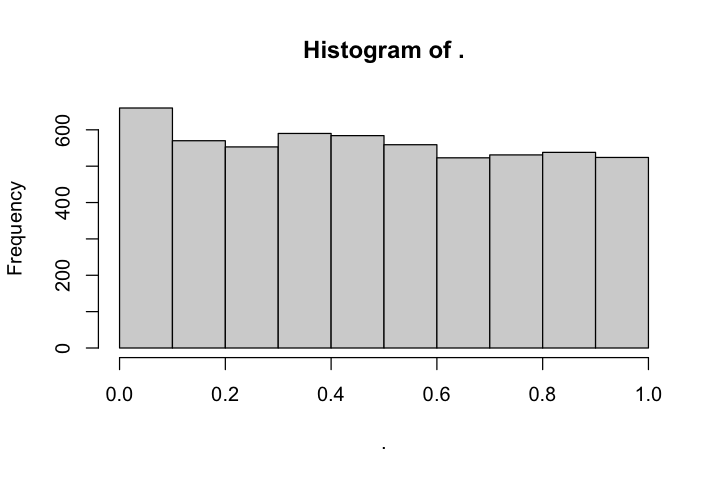

In [176]:
# Modeling Jurkats as requested. 
## Linear modeling with negative binomial. 
## Looking at Jurkats only and removing control cells. 


df <- na.omit(meta_umap.clust %>% filter(cluster == 0 & Edited == "Edited"))
cells <- df %>% with(cell) 

#Filter on expression in at least 30% of cells
Exprs <- full_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]

suppressWarnings({
FBXO11_lm_Jurkat <- 
    sapply(rownames(Exprs), function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_RNA) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_RNA) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Jurkat<- FBXO11_lm_Jurkat %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Jurkat %>% with(pval) %>% hist
FBXO11_lm_Jurkat <- FBXO11_lm_Jurkat %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))


## Modeling Jurkats - Condition

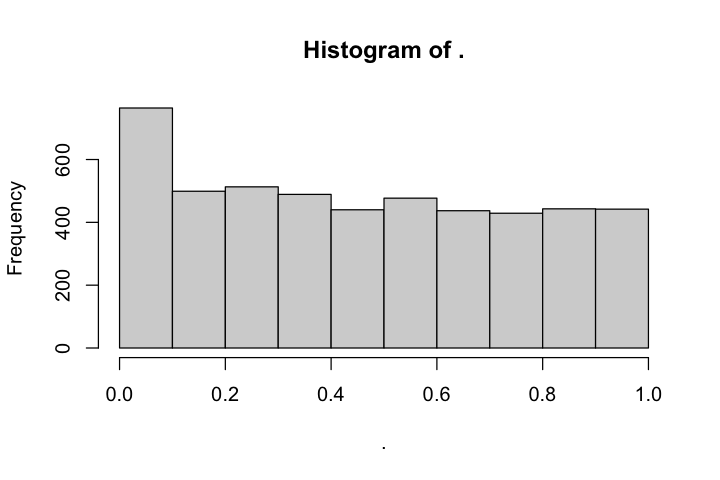

In [150]:
## Linear modeling with negative binomial. 
## Looking at Jurkats only and removing control cells. 

df <- na.omit(meta_umap.clust %>% filter(cluster == 0)) #Jurkats by RNA clustering
cells <- df %>% with(cell) 

nCells = rowSums(full_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 30% of cells
Exprs <- full_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]

suppressWarnings({
FBXO11_lm_J_Edited <- 
    sapply(rownames(Exprs), function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_RNA) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_RNA) + Plate + Edited
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_J_Edited<- FBXO11_lm_J_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_J_Edited %>% with(pval) %>% hist
FBXO11_lm_J_Edited <- FBXO11_lm_J_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [178]:
#Create a joint data frame. 
jointviolindataJurkat <- rbind(mutate(FBXO11_lm_Jurkat, group = "Dosage"), 
                         mutate(FBXO11_lm_J_Edited, group = "Edited"))


In [215]:
#Add pval thresholds for significance - FDR empirical. 
jointviolindataJurkat <- mutate(jointviolindataJurkat, "threshold" = 
                                ifelse(group == "Dosage", 
                                       (FBXO11_lm_Jurkat %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval)),
                                        (FBXO11_lm_J_Edited %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval))))

Warning message in geom_point(data = . %>% filter(Genes %in% adtlabels), aes(beta, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 5632 rows containing missing values or values outside the scale range
(`geom_abline()`).”


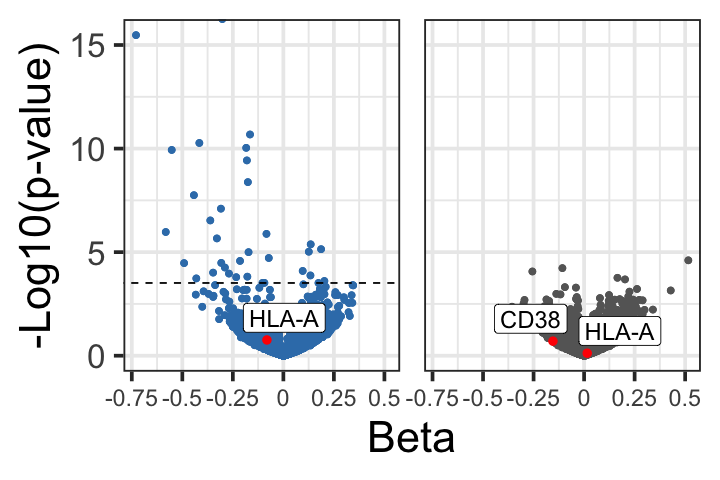

In [231]:
#Plot Together
library(scales)
fig.size(4,6)
adtlabels <- c("CD40", "HLADR", "HLA-A", "CD38", "CD22")
genelabels <- c("FBXO11", "CD40", "HLA-DRA", "HLA-A", "CD38")

g1 <- jointviolindataJurkat %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
theme(legend.position = "none") + 
geom_abline(aes(intercept = -log10((threshold)), slope = 0), linetype = 2)+ 
ylab("-Log10(p-value)")+ 
    theme(axis.text.x = element_text(size = 14),axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))  +
scale_x_continuous(labels = scales::label_number(drop0trailing=TRUE)) + xlab("Beta")
    } 


g1

In [232]:
FBXO11_lm_J_Edited %>% filter(padj < 0.05)

Genes   pval         beta        padj        
1  LDHA    0.000000e+00 -0.30202796 0.000000e+00
2  DDIT4   3.330669e-16 -0.72910400 8.215095e-13
3  PKM     2.086786e-11 -0.16499450 3.431372e-08
4  COTL1   5.366463e-11 -0.41577766 6.618190e-08
5  TPI1    9.216483e-11 -0.18391206 9.092982e-08
6  BNIP3   1.166482e-10 -0.55249401 9.590430e-08
7  ENO1    3.726167e-10 -0.18053350 2.625883e-07
8  PGK1    4.159343e-09 -0.17565969 2.564755e-06
9  S100A10 1.776666e-08 -0.44265240 9.738106e-06
10 FAM162A 7.961292e-08 -0.30901466 3.927305e-05
11 HLA-B   2.945725e-07 -0.36152907 1.321024e-04
12 LGMN    1.066143e-06 -0.58198918 4.382734e-04
13 MIF     1.312754e-06 -0.08364278 4.981396e-04
14 BNIP3L  2.173509e-06 -0.32893566 7.658516e-04
15 H3F3B   4.190539e-06  0.13526825 1.378129e-03
16 CIRBP   7.192450e-06  0.18663164 2.217522e-03
17 YWHAQ   9.536179e-06  0.12580560 2.743133e-03
18 GPI     1.000940e-05 -0.17232096 2.743133e-03
19 GAPDH   1.914575e-05 -0.07218560 4.970842e-03
20 WDR54   2.652450e-05 -0.21445047 6.542269e-03
21 IGFBP2  3.304325e-05 -0.30727785 7.578482e-03
22 CD52    3.379822e-05 -0.49120040 7.578482e-03
23 ZFP36L2 5.532864e-05 -0.28941512 1.186679e-02
24 HMGB1   8.086020e-05  0.09562022 1.662014e-02
25 P2RY8   9.751391e-05 -0.34767514 1.924144e-02
26 PDLIM1  1.083220e-04 -0.26920374 2.055202e-02
27 RAC1    1.333384e-04  0.13396055 2.436142e-02
28 NARF    1.525536e-04 -0.17823452 2.687668e-02
29 GNA15   1.617522e-04 -0.23331889 2.751460e-02
30 ZFAND1  1.854123e-04 -0.43082721 3.048796e-02
31 FERMT3  2.471320e-04  0.20288657 3.932588e-02
32 TMSB4X  3.036766e-04 -0.09386924 4.466713e-02
33 PGAM1   3.073214e-04 -0.10360311 4.466713e-02
34 SF3B4   3.078618e-04  0.17364407 4.466713e-02

## Venn Diagram - Jurkat vs Daudi

In [416]:
#Intesections and differences
featurex <- joint_FBXO11_lm_Edited %>% filter(padj < 0.05) %>% with(Genes)
featurey <- FBXO11_lm_J_Edited %>% filter(padj < 0.05) %>% with(Genes)

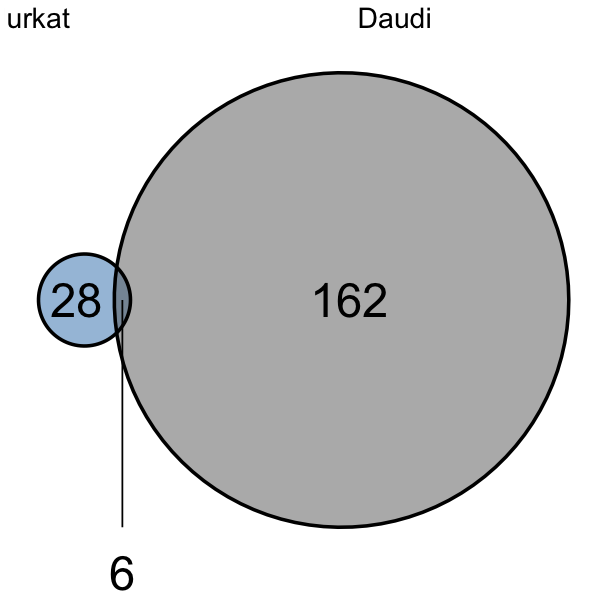

In [417]:
fig.size(5,5)
g2 <- ggvenn(list("Jurkat" = featurey, "Daudi" = featurex),
      auto_scale = T, 
      fill_color = c("#377EB8","grey40"), 
      text_size = 10, 
      show_percentage = F)

plot(g2)
ggsave(filename = "Genes_FBXO11.png", device = png, plot = g2,width = 1, height = 1)

## ADT - Daudi - Genotype

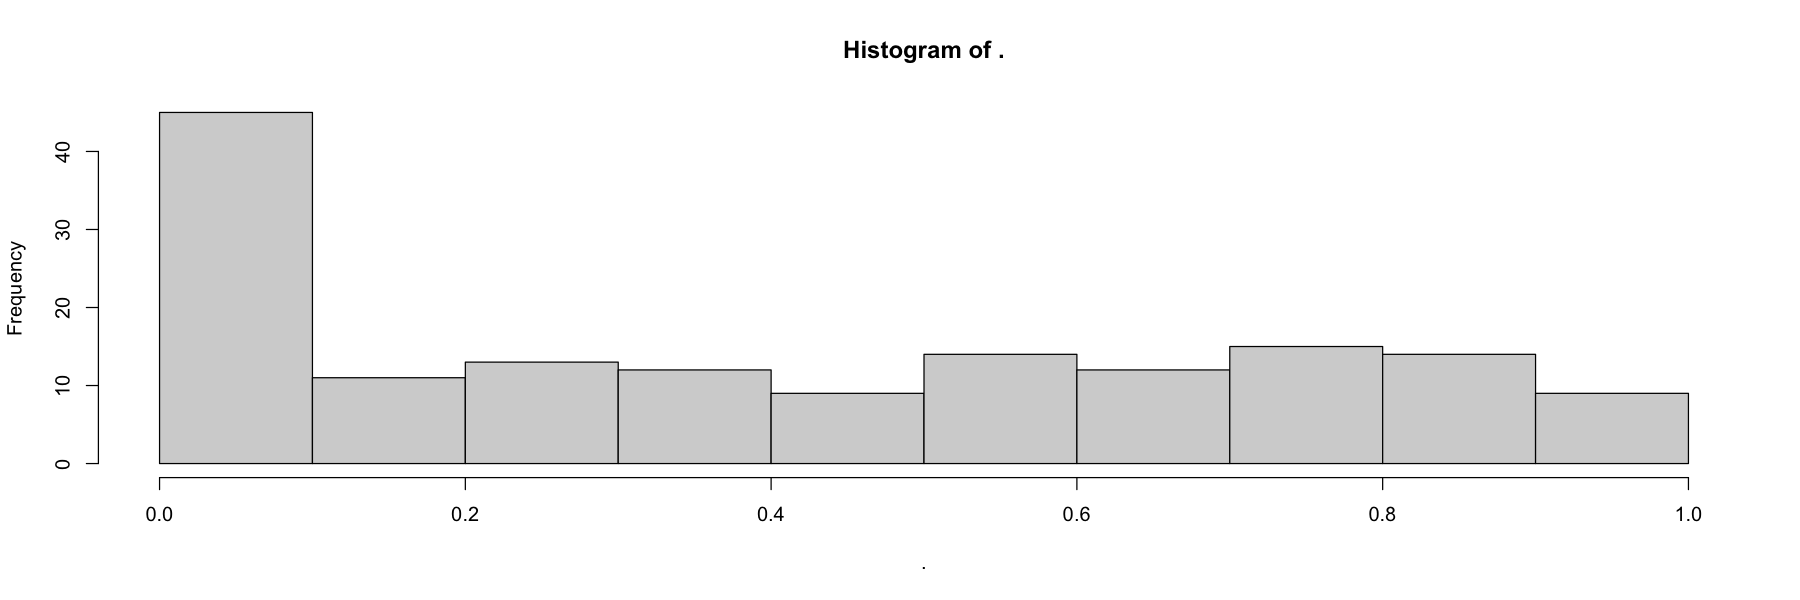

In [710]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 

df <- na.omit(meta_umap.clust %>% filter(cluster == 1 & Edited == "Edited"))
cells <- df %>% with(cell) #Daudis

Exprs <- full_adt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt<- FBXO11_lm_Daudi_adt %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt <- FBXO11_lm_Daudi_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [1093]:
FBXO11_lm_Daudi_adt %>% write_csv("joint_FBXO11_lm_adt.csv")

## ADT - Daudi - Condition

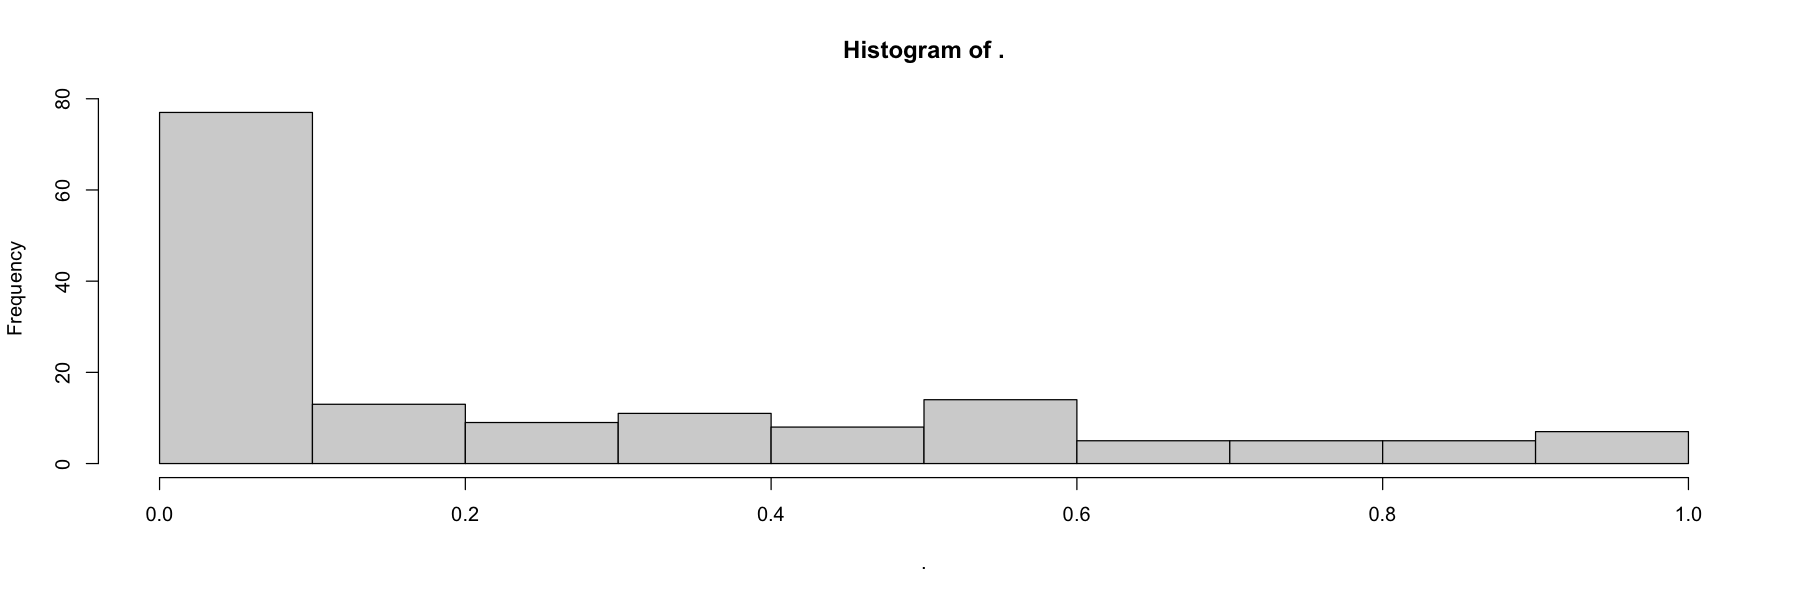

In [731]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
df <- na.omit(meta_umap.clust %>% filter(cluster == 1))
cells <- df %>% with(cell) #Daudis

Exprs <- full_adt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + Plate + Edited
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt_Edited<- FBXO11_lm_Daudi_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt_Edited <- FBXO11_lm_Daudi_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [1092]:
FBXO11_lm_Daudi_adt_Edited %>% write_csv("joint_FBXO11_lm_adt_Edited.csv")

## Venn Diagram Comparing Condition vs Genotype

In [243]:
library("ggvenn")

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern




In [422]:
FBXO11_lm_Daudi <- read_csv("joint_FBXO11_lm.csv")
FBXO11_lm_Daudi_Edited <- read_csv("joint_FBXO11_lm_Edited.csv")
FBXO11_lm_Daudi_adt <- read_csv("joint_FBXO11_lm_adt.csv")
FBXO11_lm_Daudi_adt_Edited <- read_csv("joint_FBXO11_lm_adt_Edited.csv")

Rows: 4604 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Genes
dbl (3): pval, beta, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4604 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Genes
dbl (3): pval, beta, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 154 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Genes
dbl (3): pval, beta, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 154 Columns: 4
── Column specification ──────────────

In [423]:
#Intesections and differences
featurex <- FBXO11_lm_Daudi %>% filter(padj < 0.05) %>% with(Genes)
featurey <- FBXO11_lm_Daudi_Edited %>% filter(padj < 0.05) %>% with(Genes)
featurexadt <- FBXO11_lm_Daudi_adt %>% filter(padj < 0.05) %>% with(Genes)
featureyadt <- FBXO11_lm_Daudi_adt_Edited   %>% filter(padj < 0.05) %>% with(Genes)

In [424]:
intersect(featurex, featurey)
intersect(featurexadt, featureyadt)
setdiff(featurey, featurex)

[1] "HLA-DRA"  "HLA-DPB1" "MPST"     "GGCT"     "TPI1"     "ABHD3"   
 [7] "STIM2"    "PSME1"    "LAPTM5"   "LCK"      "SSR2"     "MIF"     
[13] "POLD4"    "WARS"     "HLA-DRB1" "CHCHD10"  "EDF1"     "AK2"     
[19] "SHMT2"    "SLC44A2"  "CTSH"     "FAM241A"  "SLC25A6"  "TSTD1"   
[25] "IDH2"     "DDOST"    "FBXO11"   "MTF2"     "ENO1"     "LTB"     
[31] "MZB1"     "CSTB"     "CCDC112"  "HADHA"    "PNISR"    "GRN"     
[37] "HLA-B"    "UBE2L6"   "FKBP11"   "COX6A1"   "TFDP2"    "HSPD1"   
[43] "SEC11A"   "RNF187"   "ATP6V0B"  "HLA-C"    "ANK1"     "BST2"

[1] "CD40"        "CD58"        "CD27"        "HLADR"       "CD131"      
 [6] "CD72"        "HLADR_DP_DQ" "CD29"        "CD32"        "CD107a"     
[11] "CD49d"       "CD275"       "CD37"        "CD95"        "CD44"       
[16] "CD38"        "CD47"        "CD69"        "CD196"       "CD45"

[1] "PDIA6"      "HSP90B1"    "HLA-A"      "HSPA5"      "MYDGF"     
  [6] "PPIB"       "P4HB"       "TRIB3"      "CALR"       "RPL36"     
 [11] "HERPUD1"    "DDIT3"      "DNAJC1"     "ISG15"      "EEF2"      
 [16] "RPS5"       "MT-CYB"     "SEC61A1"    "TUBA1A"     "KDELR1"    
 [21] "NCF1"       "HMGN1"      "RPL10"      "ARGLU1"     "SRSF5"     
 [26] "DDX5"       "MAT2A"      "GAS5"       "PSAP"       "FUNDC2"    
 [31] "CANX"       "LIG1"       "MRPL16"     "SSR3"       "RPS19"     
 [36] "CUTC"       "TRA2B"      "TMED2"      "ANAPC11"    "DDX46"     
 [41] "ARF4"       "TMEM258"    "CDK2AP2"    "RPS28"      "SPCS2"     
 [46] "MANF"       "AC079781.5" "PDXK"       "TAF7"       "UBXN1"     
 [51] "RPL8"       "PPA1"       "ISG20"      "IFI6"       "SRSF2"     
 [56] "LRRC59"     "HLA-DMA"    "HMGA1"      "GPI"        "SERP1"     
 [61] "IER3IP1"    "TAP1"       "ACTG1"      "SPAG7"      "RRBP1"     
 [66] "ARPC5"      "DDX21"      "PDIA4"      "FCMR"       "RBX1"      
 [71] "TMED9"      "RPLP0"      "SSR4"       "PDIA3"      "CDKN2B-AS1"
 [76] "STT3A"      "MMADHC"     "RPN1"       "HLA-E"      "HM13"      
 [81] "DDIT4"      "SLC29A1"    "NENF"       "SYVN1"      "COPG1"     
 [86] "ERAP1"      "SNHG31"     "NPAS1"      "CUL1"       "H2AFZ"     
 [91] "SDF2L1"     "UTP23"      "DNAJB11"    "MRPL51"     "DTYMK"     
 [96] "DCTPP1"     "DHFR"       "NFKBIA"     "HAUS8"      "YDJC"      
[101] "CHPT1"      "TRMT6"      "C15orf61"   "HS2ST1"     "CHD4"      
[106] "SNX2"       "RPS18"      "FNBP1"      "TBC1D1"     "MYO9A"     
[111] "CD99"       "TCL1A"      "CREG1"      "UBE2T"      "TECR"      
[116] "HMCES"      "HSPA9"      "ASTN2"      "PSMD1"      "DENND2D"

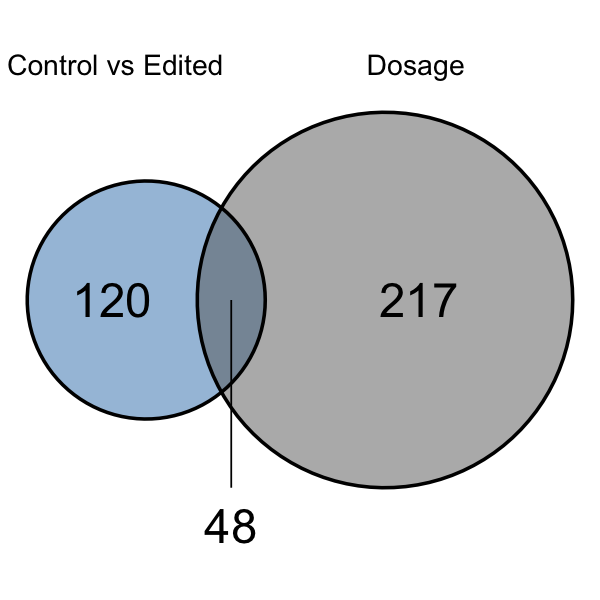

In [425]:
# fig.size(5,5)
g2 <- ggvenn(list("Control vs Edited" = featurey, "Dosage" = featurex),
      auto_scale = T, 
      fill_color = c("#377EB8","grey40"), 
      text_size = 10, 
      show_percentage = F)

plot(g2)
ggsave(filename = "Genes_FBXO11.png", device = png, plot = g2,width = 1, height = 1)

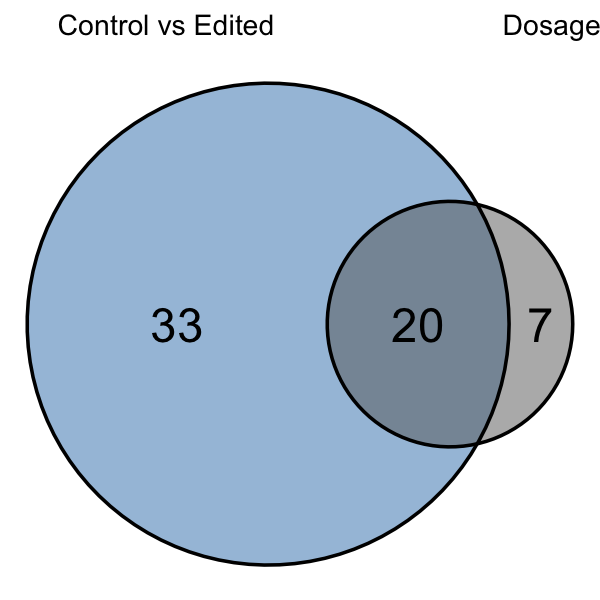

In [426]:
g2 <- ggvenn(list("Control vs Edited" = featureyadt,"Dosage" = featurexadt
             ), 
      auto_scale = T, 
      fill_color =c("#377EB8","grey40"), 
      text_size = 10, 
      show_percentage = F)


plot(g2)
ggsave(filename = "ADT_FBXO11.png", device = png, plot = g2,width = 2, height = 2)

In [427]:
jointviolindata <- rbind(mutate(FBXO11_lm_Daudi, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_Edited, group = "Edited"))

jointviolindata_adt <-rbind(mutate(FBXO11_lm_Daudi_adt, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_adt_Edited, group = "Edited"))

In [428]:
#Add pval thresholds for significance - FDR empirical. 
jointviolindata <- mutate(jointviolindata, "threshold" = 
                                ifelse(group == "Dosage", 
                                       (FBXO11_lm_Daudi %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval)),
                                        (FBXO11_lm_Daudi_Edited %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval))))

In [429]:
#Add pval thresholds for significance - FDR empirical. 
jointviolindata_adt <- mutate(jointviolindata_adt, "threshold" = 
                                ifelse(group == "Dosage", 
                                       (FBXO11_lm_Daudi_adt %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval)),
                                        (FBXO11_lm_Daudi_adt_Edited %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval))))

Warning message in geom_point(data = . %>% filter(Genes %in% adtlabels), aes(beta, :
“Ignoring unknown aesthetics: label”
Warning message in geom_point(data = . %>% filter(Genes %in% genelabels), aes(beta, :
“Ignoring unknown aesthetics: label”


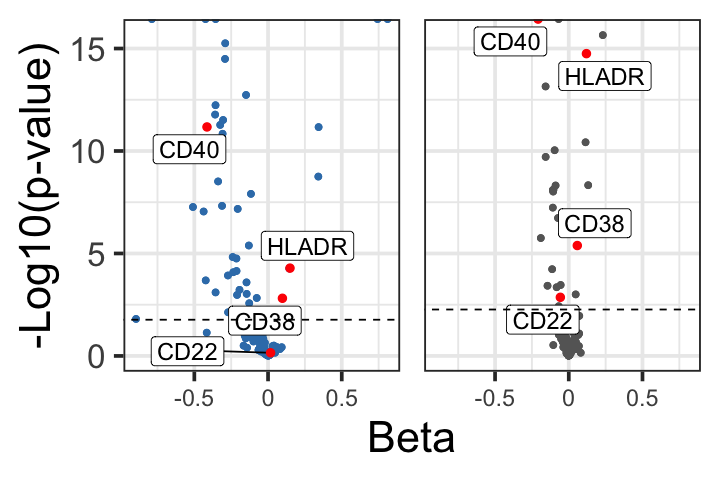

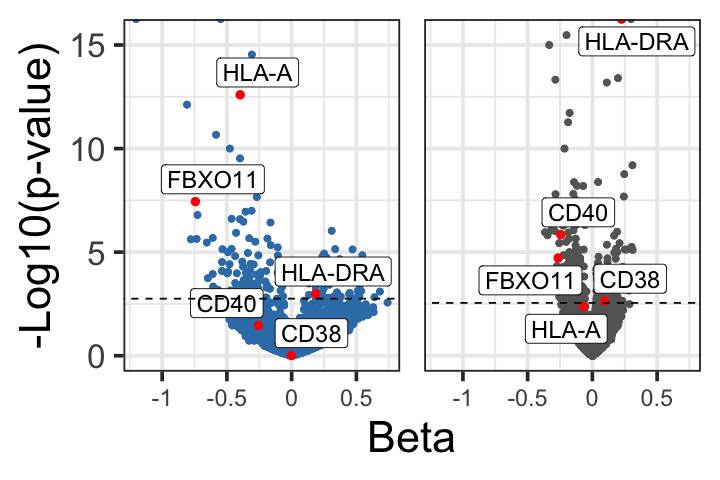

In [437]:
fig.size(4,6)
adtlabels <- c("CD40", "HLADR", "HLA-A", "CD38", "CD22")
genelabels <- c("FBXO11", "CD40", "HLA-DRA", "HLA-A", "CD38")

g1 <- jointviolindata_adt %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
theme(legend.position = "none") + 
geom_abline(aes(intercept = -log10((threshold)), slope = 0), linetype = 2)+ 
ylab("-Log10(p-value)")+ 
    theme(axis.text.x = element_text(size = 14),axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))  +
scale_x_continuous(labels = scales::label_number(drop0trailing=TRUE)) + xlab("Beta")
    } 


g1

fig.size(4,6)
g2 <- jointviolindata %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
theme(legend.position = "none") + 
geom_abline(aes(intercept = -log10((threshold)), slope = 0), linetype = 2)+ 
ylab("-Log10(p-value)")+ 
    theme(axis.text.x = element_text(size = 14),axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))  +
scale_x_continuous(labels = scales::label_number(drop0trailing=TRUE)) + xlab("Beta")
    } 


g2





In [438]:
jointviolindata %>% filter(Genes == "FBXO11")

Genes  pval             beta       padj          group  threshold  
1 FBXO11 0.00001925380418 -0.2641031 0.00128470311 Dosage 0.002821907
2 FBXO11 0.00000003638408 -0.7435979 0.00001288556 Edited 0.001764942

### Function for plotting residuals

In [281]:
ResidualsPlot <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% 
    inner_join(meta_umap.clust, by ="cell")%>% na.omit() %>% filter(cluster %in% 1)
#Plotting residuals
#Linear model
ADT_regressed <- glm.nb(data= df, 
   value ~ 1+ Plate + log10(nUMI_RNA))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble()
colnames(Residuals_ADT) <- "Residuals"
Residuals_ADT <- cbind(df, Residuals_ADT)

#Plot
g <- ggplot(Residuals_ADT) +  
geom_boxplot(outlier.alpha = 0,
             aes(Edited, `Residuals`, color = Edited)) + 
geom_boxplot(outlier.alpha = 0, 
             data = filter(Residuals_ADT, Edited != "Control"),
             aes(as.factor(Dosage), `Residuals`, color = as.factor(Dosage))) +
geom_jitter(aes(Edited, `Residuals`, color = Edited), 
           alpha = 0.1) + 
geom_jitter(data = filter(Residuals_ADT, Edited != "Control"),
             aes(as.factor(Dosage), `Residuals`, color = as.factor(Dosage)), 
           alpha = 0.1) + 

    
theme_gy(18)+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "0",
                           "1", 
                           "2"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
              "Control" = "#E41A1C",
              "Edited" = "#377EB8",
              "0" = "#DD1C77", 
              "1" = "#C994C7",
              "2" = "grey40"))+ 
xlab("") + 
ylab("Residuals")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster) +theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster)  + 
    theme(strip.text = element_blank()) 
return(
plot(g))
}

## Figures

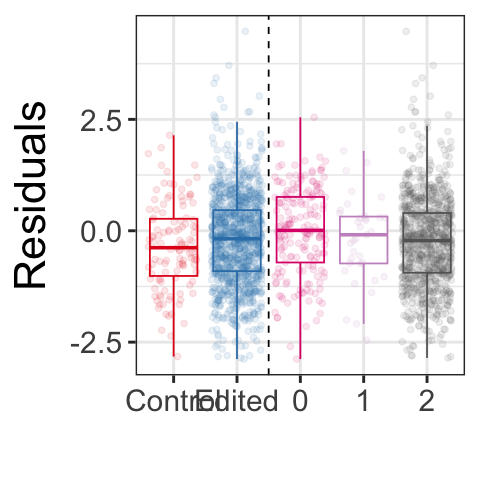

In [282]:
fig.size(4,4)
ResidualsPlot(full_adt, "CD22")

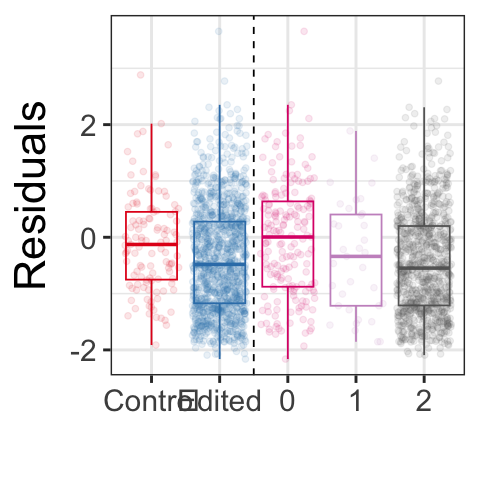

In [286]:
fig.size(4,4)
ResidualsPlot(full_exprs, "CD40")

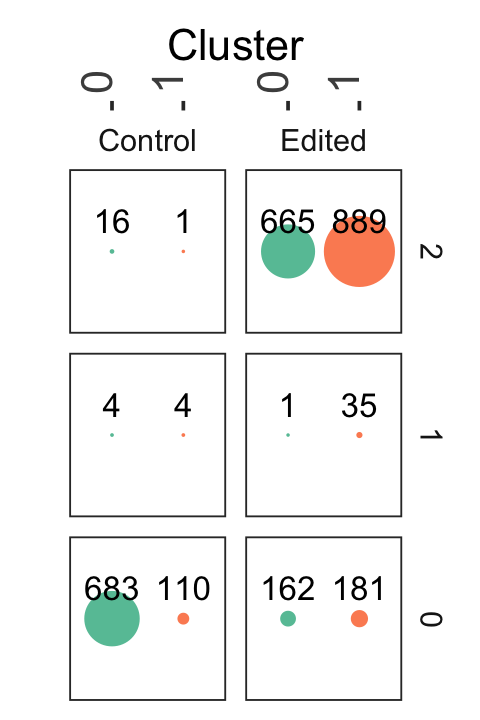

In [868]:
test2 <- meta_umap.clust %>% filter(cluster %in% c(0,1)) %>% na.omit()

#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(-`n`)
order <- as.character(order$`.`)

fig.size(6,4)
g <- 

table(test2$Dosage,test2$cluster, test2$Edited) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var3, genotype = Var1, Cluster = Var2) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(Cluster,fill=Cluster,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =7, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor(genotype,levels = c("2","1","0"))~ 
               CellType) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        )+ 
    scale_fill_manual(values = c("2"='#8DA0CB',
                                  "0" = '#66C2A5',
                                  "1"='#FC8D62'))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "FBXO11_Genotypes.png", device = "png", dpi = 300, width = 4, height = 6)
    })


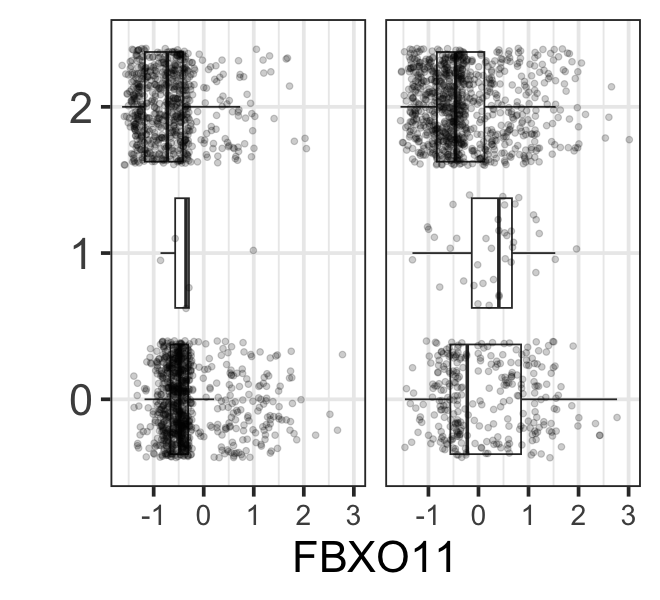

In [871]:
fig.size(5, 5.5)

Residuals_ADT %>%{
ggplot(.) +  
geom_boxplot(outlier.alpha = 0,
             aes(factor((Dosage), levels = c("0","1","2")), `Residuals`)) + 

geom_jitter(aes(factor((Dosage)), `Residuals`), 
           alpha = 0.2) + 
theme_gy()+
#scale_x_discrete(limits = c("Control", 
 #                          "Edited", 
  #                         "A/A",
   #                        "A/G", 
    #                       "G/G"
     #                      )) + 

xlab("") + 
ylab("FBXO11")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster) 
    } + coord_flip() + 
    theme(strip.text = element_blank(), axis.text.x = element_text(size = 17))